In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
import xgboost as xgb
from catboost import CatBoostRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import os

In [6]:
#
#
#
# 5 minutes df
#
#
#

In [258]:
df_5min = pd.read_csv('cleaned_XAUUSD_5_M_01.01.2024-29.03.2025.csv', low_memory=False, sep=',')

In [259]:
df_5min.iloc[5000:5007]

,date,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,...,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week,Y_High_BID,Y_Low_ASK
5000,2024-01-18 08:40:00+00:00,2.010345,2.010895,2.010235,2.010585,0.016843,2.010055,2.010605,2.009945,2.010265,...,0.347336,0.024797,0.29,0.290,0.29,0.32,0,0,2.010605,2.010235
5001,2024-01-18 08:45:00+00:00,2.010575,2.010985,2.010235,2.010255,0.019038,2.010265,2.010698,2.009945,2.009965,...,0.345207,0.028140,0.31,0.287,0.29,0.29,0,0,2.010698,2.010235
5002,2024-01-18 08:50:00+00:00,2.010235,2.010695,2.009935,2.010195,0.013730,2.009945,2.010395,2.009635,2.009845,...,0.361128,0.003140,0.29,0.300,0.30,0.35,0,0,2.010395,2.009935
5003,2024-01-18 08:55:00+00:00,2.010205,2.010435,2.009825,2.009945,0.033064,2.009865,2.010125,2.009525,2.009595,...,0.375043,0.018708,0.34,0.310,0.30,0.35,0,0,2.010125,2.009825
5004,2024-01-18 09:00:00+00:00,2.009925,2.009925,2.008415,2.009185,0.045285,2.009585,2.009585,2.008075,2.008865,...,0.353645,0.014891,0.34,0.340,0.34,0.32,0,0,2.009585,2.008415
5005,2024-01-18 09:05:00+00:00,2.009185,2.009705,2.009055,2.009175,0.044521,2.008855,2.009355,2.008725,2.008865,...,0.378051,0.023432,0.33,0.350,0.33,0.31,0,0,2.009355,2.009055
5006,2024-01-18 09:10:00+00:00,2.009215,2.010065,2.008615,2.009665,0.023355,2.008905,2.009775,2.008325,2.009325,...,0.335157,0.043919,0.31,0.290,0.29,0.34,0,0,2.009775,2.008615


In [260]:
df_5min_informer = pd.read_csv('./cleaned_XAUUSD_5_M_01.01.2024-29.03.2025_for_informer.csv')

In [261]:
df_5min_informer.head()

,date,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
0,2024-01-01 00:00:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0
1,2024-01-01 00:05:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0
2,2024-01-01 00:10:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0
3,2024-01-01 00:15:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0
4,2024-01-01 00:20:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.363128,0.0,0.424,0.424,0.424,0.424,0,0


In [142]:
'''
We will predict the Highest and Lowest prices for the next 5 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 5 minutes up (1 row)

Then you need to delete the last row since there are no prices for the next 5 minutes.
Therefore, we will create an array of answers "data_ay" with the 
Highest and Lowest prices shifted sequentially to 1 row up.
'''

'\nWe will predict the Highest and Lowest prices for the next 5 minutes.\n\nTo do this in the data output (vector of answers), we shift prices sequentially to 5 minutes up (1 row)\n\nThen you need to delete the last row since there are no prices for the next 5 minutes.\nTherefore, we will create an array of answers "data_ay" with the \nHighest and Lowest prices shifted sequentially to 1 row up.\n'

In [262]:
inputs_data = df_5min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(118096, 18)

In [263]:
outputs_data = df_5min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(118096, 2)

In [264]:
print(outputs_data.tail(2), '\n')
outputs_data = outputs_data.shift(-1)
print(outputs_data.tail(2))

        Y_High_BID  Y_Low_ASK
118094    3.083898   3.086702
118095    3.083898   3.086702 

        Y_High_BID  Y_Low_ASK
118094    3.083898   3.086702
118095         NaN        NaN


In [265]:
outputs_data.drop(outputs_data.shape[0]-1, axis=0, inplace=True)
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
118093,3.083898,3.086702
118094,3.083898,3.086702


In [266]:
inputs_data.drop(inputs_data.shape[0]-1, axis=0, inplace=True)
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
118093,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0
118094,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0


In [267]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (118095, 18) 
outputs Numpy array size: (118095, 2)


In [268]:
# We need a three-dimensional data tensor: [(nb of rows - N), N, 20] and
# two-dimensional array of answers [(nb of rows - N), 2] with the High and Low prices DURING the next 5 minutes
# where N=25 (~2 hours '125 minutes') is the number of minutes for analysis at each step; those are looking backwards

In [269]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 118070 25 18


In [270]:
# create inputs zeros 3D tensors with 'float32'
data_in = np.zeros( (L, N, t), dtype= 'float32' )

# create a 2D zeros vector of answers
data_out = np.zeros((L, 2), dtype= 'float32')

In [271]:
# fill the inputs 3D tensor (data_in)
# and the array of answers data_out

for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]   # normalised Y_High_Bid - max 10 minutes future price
    data_out[k,1] = data_y[k+N-1,1]   # normalised Y_Low_Ask -  min 10 minutes future price

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|██████████████████████████████████████████████████████████████████████| 118070/118070 [00:00<00:00, 180883.39it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [272]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (118070, 25, 18) 
outputs 2D vector size: (118070, 2)


In [273]:
def walk_forward_split(X, y, train_size, test_size):
    X_train_blocks, X_test_blocks = [], []
    y_train_blocks, y_test_blocks = [], []

    start = 0
    while (start + train_size + test_size) <= len(X):
        end_train = start + train_size
        end_test = end_train + test_size

        X_train_blocks.append(X[start:end_train])
        X_test_blocks.append(X[end_train:end_test])
        y_train_blocks.append(y[start:end_train])
        y_test_blocks.append(y[end_train:end_test])

        start += train_size
    '''
    # Add remaining samples to the LAST BLOCK instead of creating a new one
    remaining = len(X) - start
    if remaining > 0:
        # Append to last train/test blocks
        start = start-train_size
        last_end_train = len(X)-test_size

        X_train_blocks[-1] = X[start:last_end_train]
        y_train_blocks[-1] = y[start:last_end_train]

        X_test_blocks[-1] = X[last_end_train:len(X)]
        y_test_blocks[-1] = y[last_end_train:len(X)]
    '''
    return X_train_blocks, X_test_blocks, y_train_blocks, y_test_blocks

In [274]:
def walk_forward_split_for_informer(df, output_dir, train_size, test_size):
    """
    df: full DataFrame
    output_dir: folder direction to save the blocks in
    train_size: number of samples in training set
    test_size: number of samples in test set
    """
    os.makedirs(output_dir, exist_ok=True)
    block_counter = 0
    start = 0
    
    while (start + train_size + test_size) <= len(df):
        end_train = start + train_size
        end_test = end_train + test_size

        print(f"Start: {start} | End Train: {end_train} | End Test: {end_test}")
        
        sub_df = df.iloc[start:end_test]
        output_path = os.path.join(output_dir, f"walk_forward_block_{block_counter}.csv")
        sub_df.to_csv(output_path, index=False)
        print(f"Block {block_counter} | Rows: {sub_df.shape[0]} | Columns: {sub_df.shape[1]} | Path: {output_path}")
        
        start += train_size
        block_counter += 1
        
    return block_counter

In [275]:
train_size, test_size = 16500, 2500

In [276]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [277]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 7
Shape of first training block X: (16500, 25, 18)
Shape of first testing block X: (2500, 25, 18)
Shape of last training block X: (16500, 25, 18)
Shape of last testing block X: (2500, 25, 18)


In [278]:
number_of_blocks_for_informer = walk_forward_split_for_informer(df_5min_informer, './walk_forward_data_split_informer', train_size, test_size)

Start: 0 | End Train: 16500 | End Test: 19000
Block 0 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_0.csv
Start: 16500 | End Train: 33000 | End Test: 35500
Block 1 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_1.csv
Start: 33000 | End Train: 49500 | End Test: 52000
Block 2 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_2.csv
Start: 49500 | End Train: 66000 | End Test: 68500
Block 3 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_3.csv
Start: 66000 | End Train: 82500 | End Test: 85000
Block 4 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_4.csv
Start: 82500 | End Train: 99000 | End Test: 101500
Block 5 | Rows: 19000 | Columns: 19 | Path: ./walk_forward_data_split_informer\walk_forward_block_5.csv
Start: 99000 | End Train: 115500 | End Test: 118000
Block 6 | Rows: 19000 | Col

In [279]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer}")

Number of walk-forward blocks for training Informer: 7


In [280]:
#
# LSTM-XGBOOST model
#

In [282]:
results_next_5min_LSTM_XGB = []

In [281]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [283]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_5min_LSTM_XGB.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.3109 - val_loss: 8.5936e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.1646e-04 - val_loss: 9.9460e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.0132e-05 - val_loss: 8.9704e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3.9553e-05 - val_loss: 7.8739e-04
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.5279e-05 - val_loss: 7.7885e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.7560e-05 - val_loss: 7.4569e-04
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.9089e-05 - val_loss: 7.2135e-04
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.3651e-05 - val_loss: 6.8081e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.2140e-05 - val_loss: 6.4676e-04
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.6796e-05 - val_loss: 5.9954e-04
Epoch 11/100
4

In [284]:
metrics_next_5min_LSTM_XGB = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_5min_LSTM_XGB = {metric: np.mean([r[metric] for r in results_next_5min_LSTM_XGB]) for metric in metrics_next_5min_LSTM_XGB}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_5min_LSTM_XGB.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0124
Average rmse_low_ask: 0.0123
Average mae_high_bid: 0.0068
Average mae_low_ask: 0.0070
Average r2_high_bid: 0.6191
Average r2_low_ask: 0.6303


In [285]:
#
# LSTM-CATBOOST model
#

In [286]:
results_next_5min_LSTM_CAT = []

In [287]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])
LSTM_model_for_cat.summary()
LSTM_model_for_cat.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [288]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_5min_LSTM_CAT.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1304 - val_loss: 5.3848e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1.5765e-04 - val_loss: 4.4645e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.4567e-05 - val_loss: 3.1932e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.7409e-05 - val_loss: 2.4990e-04
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.6404e-05 - val_loss: 2.1690e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.9829e-05 - val_loss: 2.0121e-04
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.1433e-05 - val_loss: 1.8285e-04
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 2.3527e-05 - val_loss: 1.5976e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.9880e-05 - val_loss: 1.7281e-04
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2.0373e-05 - val_loss: 1.8491e-04
Epoch 11/100


In [289]:
metrics_next_5min_LSTM_CAT = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_5min_LSTM_CAT = {metric: np.mean([r[metric] for r in results_next_5min_LSTM_CAT]) for metric in metrics_next_5min_LSTM_CAT}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_5min_LSTM_CAT.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0097
Average rmse_low_ask: 0.0097
Average mae_high_bid: 0.0061
Average mae_low_ask: 0.0061
Average r2_high_bid: 0.7992
Average r2_low_ask: 0.7934


In [290]:
#
# Informer model
#

In [291]:
#!git clone https://github.com/zhouhaoyi/Informer2020.git

In [292]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '5min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [293]:
Informer_model = Exp_Informer

In [294]:
results_next_5min_Informer = []

In [295]:
results_dir = './results'

for i in range(number_of_blocks_for_informer):
    args.data_path = f'walk_forward_data_split_informer/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_5min_Informer.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl288_ll144_pl1_dm256_nh8_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 13012
val 1900
test 3800
	iters: 100, epoch: 1 | loss: 0.4669648
	speed: 3.1939s/iter; left time: 12651.1757s
	iters: 200, epoch: 1 | loss: 0.2103928
	speed: 3.1881s/iter; left time: 12309.1421s
	iters: 300, epoch: 1 | loss: 0.6623926
	speed: 3.1558s/iter; left time: 11869.1214s
	iters: 400, epoch: 1 | loss: 0.2269505
	speed: 3.1785s/iter; left time: 11636.3826s
Epoch: 1 cost time: 1291.8692519664764
Epoch: 1, Steps: 406 | Train Loss: 0.3473496 Vali Loss: 0.3546216 Test Loss: 1.0852619
Validation loss decreased (inf --> 0.354622).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1720751
	speed: 5.5527s/iter; left time: 19739.9616s
	iters: 200, epoch: 2 | loss: 0.1600480
	speed: 3.2262s/iter; left time: 11146.5033s
	iters: 300, epoch: 2 | loss: 0.1132541
	speed: 3.2344s/iter; left time: 10851.5413s
	iters: 400, e

In [296]:
metrics_next_5min_Informer = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_5min_Informer = {metric: np.mean([r[metric] for r in results_next_5min_Informer]) for metric in metrics_next_5min_Informer}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_5min_Informer.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.2795
Average rmse_low_ask: 0.2726
Average mae_high_bid: 0.1702
Average mae_low_ask: 0.1626
Average r2_high_bid: 0.7637
Average r2_low_ask: 0.7976


In [297]:
#
# Visualisation
#

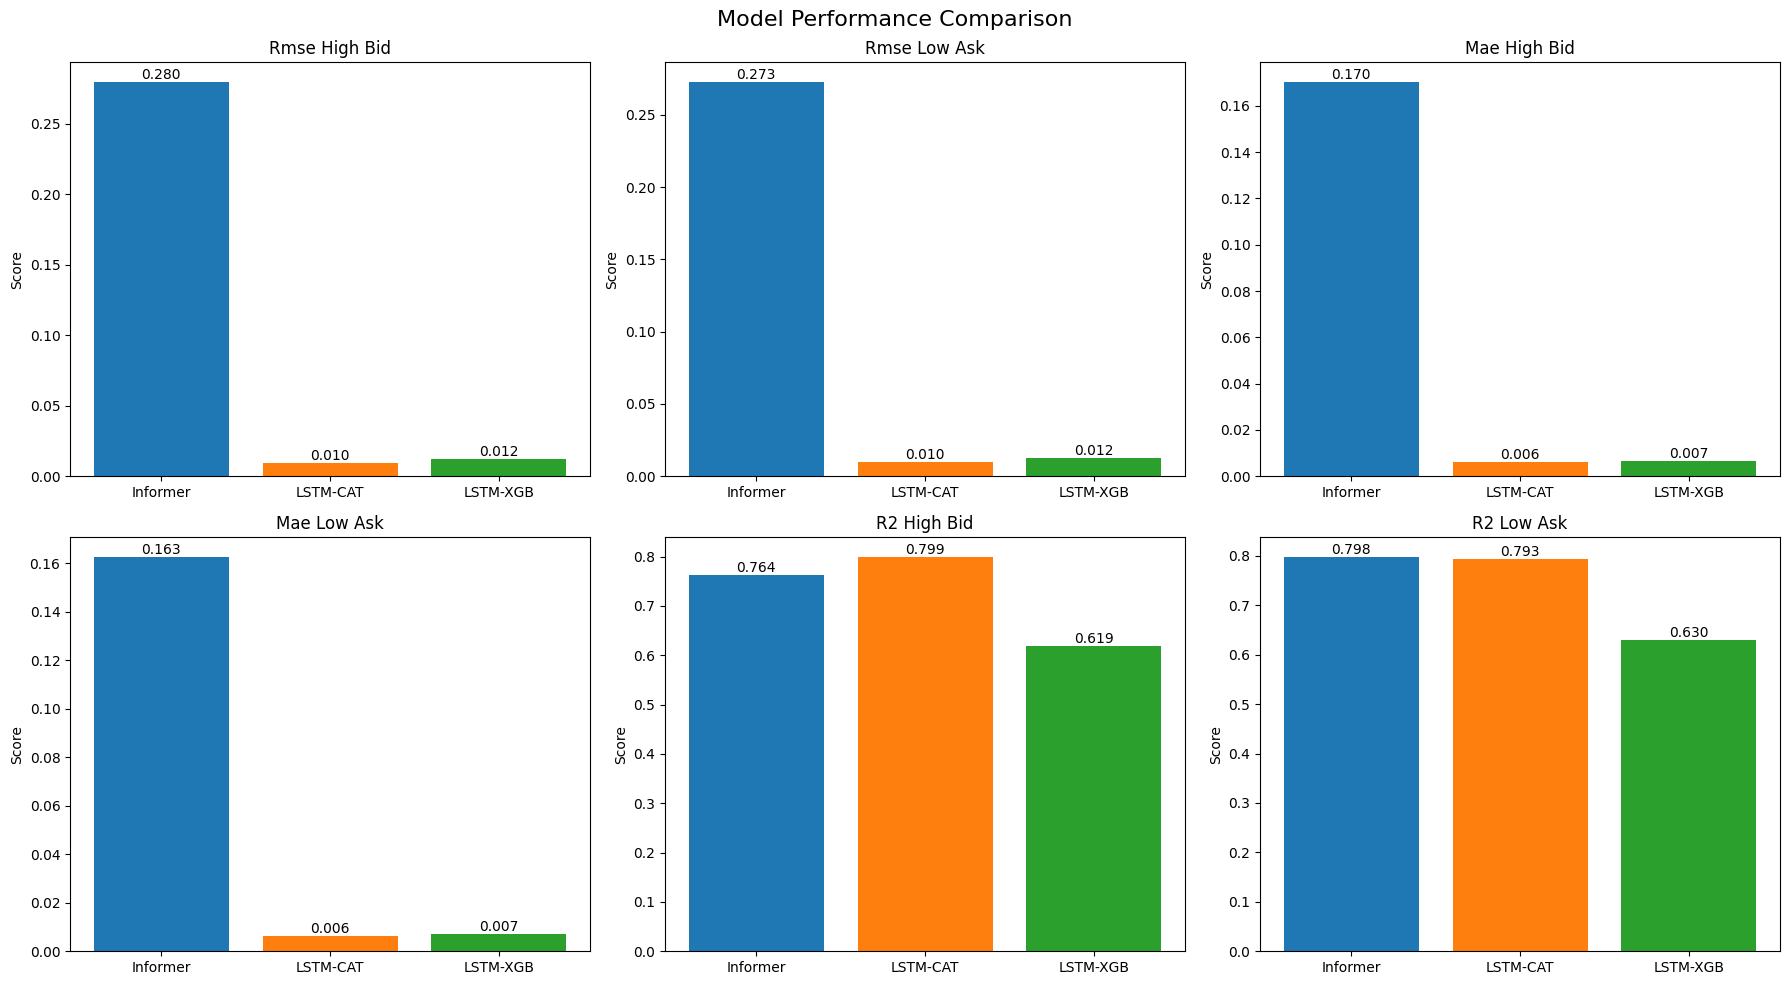

In [298]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_5min_Informer,
    'LSTM-CAT': avg_results_next_5min_LSTM_CAT,
    'LSTM-XGB': avg_results_next_5min_LSTM_XGB
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

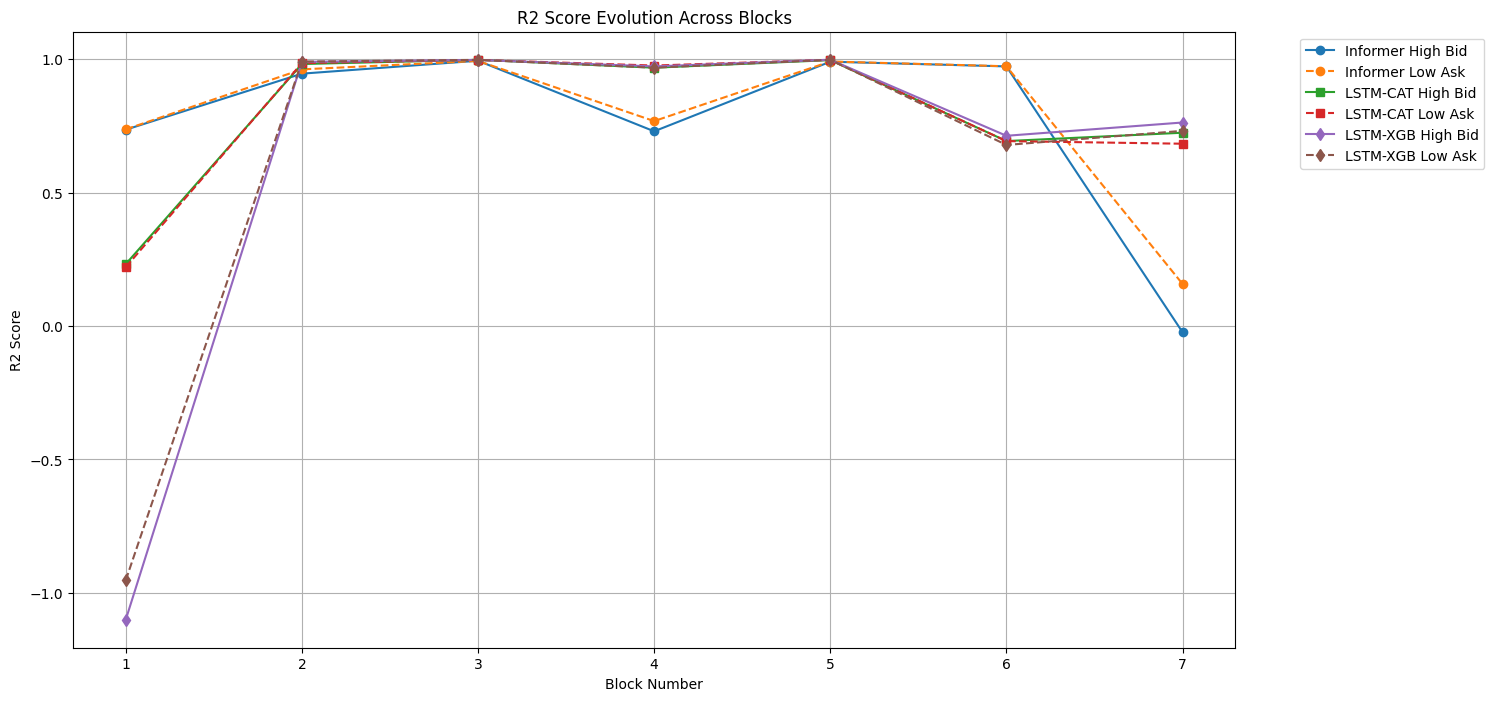

In [299]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_5min_Informer)+1)

# Create figure
plt.figure(figsize=(15, 8))

# Plot R2 evolution
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_5min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_5min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

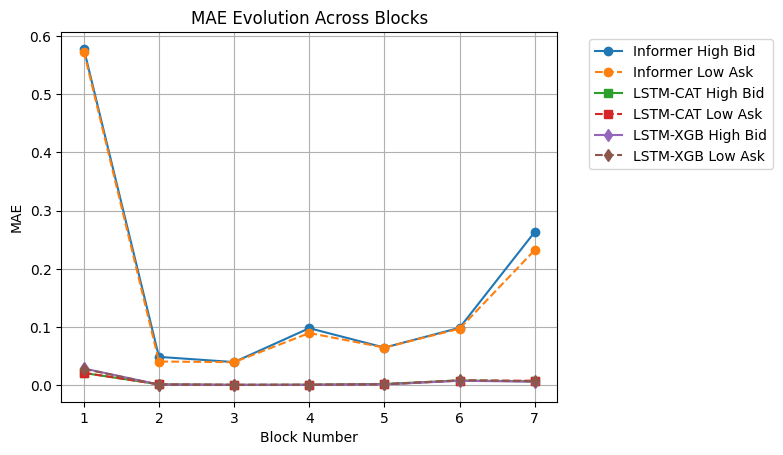

In [300]:
# Plot MAE evolution
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_5min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_5min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 15 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 15 minutes up (3 rows)

Then you need to delete the last 3 rows since there are no prices for the next 15 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 3 rows up.
'''

In [13]:
inputs_data = df_5min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(118096, 18)

In [14]:
outputs_data = df_5min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(118096, 2)

In [15]:
print(outputs_data.tail(4), '\n')
outputs_data = outputs_data.shift(-3)
print(outputs_data.tail(4))

        Y_High_BID  Y_Low_ASK
118092    3.083898   3.086702
118093    3.083898   3.086702
118094    3.083898   3.086702
118095    3.083898   3.086702 

        Y_High_BID  Y_Low_ASK
118092    3.083898   3.086702
118093         NaN        NaN
118094         NaN        NaN
118095         NaN        NaN


In [16]:
#outputs_data.drop(outputs_data.shape[0]-1, axis=0, inplace=True)
outputs_data = outputs_data.iloc[:-3]
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
118091,3.083898,3.086702
118092,3.083898,3.086702


In [17]:
#inputs_data.drop(inputs_data.shape[0]-1, axis=0, inplace=True)
inputs_data = inputs_data.iloc[:-3]
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
118091,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0
118092,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0


In [18]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (118093, 18) 
outputs Numpy array size: (118093, 2)


In [19]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 118068 25 18


In [20]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [21]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|██████████████████████████████████████████████████████████████████████| 118068/118068 [00:00<00:00, 147214.10it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [22]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (118068, 25, 18) 
outputs 2D vector size: (118068, 2)


In [26]:
train_size, test_size = 16500, 2500

In [27]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [28]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 7
Shape of first training block X: (16500, 25, 18)
Shape of first testing block X: (2500, 25, 18)
Shape of last training block X: (16500, 25, 18)
Shape of last testing block X: (2500, 25, 18)


In [29]:
#
# LSTM-XGBOOST model
#

In [30]:
results_next_15min_LSTM_XGB = []

In [31]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_15min_LSTM_XGB.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.1784 - val_loss: 5.1323e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 1.6233e-04 - val_loss: 1.3183e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 9.4853e-05 - val_loss: 8.5824e-05
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 4.6760e-05 - val_loss: 5.5840e-05
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 3.3450e-05 - val_loss: 7.6394e-05
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2.7678e-05 - val_loss: 6.5644e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 2.0812e-05 - val_loss: 4.9043e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 1.7534e-05 - val_loss: 9.5082e-05
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 1.5059e-05 - val_loss: 6.7884e-05
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9669e-05 - val_loss: 4.3251e-05
Epoch 11/1

In [33]:
metrics_next_15min_LSTM_XGB = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_LSTM_XGB = {metric: np.mean([r[metric] for r in results_next_15min_LSTM_XGB]) for metric in metrics_next_15min_LSTM_XGB}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_LSTM_XGB.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0097
Average rmse_low_ask: 0.0099
Average mae_high_bid: 0.0058
Average mae_low_ask: 0.0061
Average r2_high_bid: 0.8028
Average r2_low_ask: 0.7968


In [34]:
#
# LSTM-CATBOOST model
#

In [35]:
results_next_15min_LSTM_CAT = []

In [36]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_15min_LSTM_CAT.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0606 - val_loss: 4.0018e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7.5655e-05 - val_loss: 2.1449e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.2159e-05 - val_loss: 1.7286e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4.9054e-05 - val_loss: 1.7353e-04
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.8589e-05 - val_loss: 1.5147e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.8767e-05 - val_loss: 1.3148e-04
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.1672e-05 - val_loss: 1.1949e-04
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.3539e-05 - val_loss: 1.0957e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.3001e-05 - val_loss: 2.2164e-04
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.2317e-05 - val_loss: 9.4201e-05
Epoch 11/100
413/41

In [38]:
metrics_next_15min_LSTM_CAT = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_LSTM_CAT = {metric: np.mean([r[metric] for r in results_next_15min_LSTM_CAT]) for metric in metrics_next_15min_LSTM_CAT}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_LSTM_CAT.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0095
Average rmse_low_ask: 0.0097
Average mae_high_bid: 0.0057
Average mae_low_ask: 0.0059
Average r2_high_bid: 0.8142
Average r2_low_ask: 0.8088


In [39]:
#
# Informer model
#

In [40]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '5min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 3 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [41]:
Informer_model = Exp_Informer

In [42]:
results_next_15min_Informer = []

In [47]:
results_dir = './results'

for i in range(number_of_blocks_for_informer):
    args.data_path = f'walk_forward_data_split_informer/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_15min_Informer.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl288_ll144_pl3_dm256_nh8_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 13010
val 1898
test 3798
	iters: 100, epoch: 1 | loss: 0.1940719
	speed: 3.9871s/iter; left time: 15793.0280s
	iters: 200, epoch: 1 | loss: 0.4989661
	speed: 3.3745s/iter; left time: 13028.9761s
	iters: 300, epoch: 1 | loss: 0.3594683
	speed: 3.3995s/iter; left time: 12785.4072s
	iters: 400, epoch: 1 | loss: 0.2475406
	speed: 3.3808s/iter; left time: 12377.0272s
Epoch: 1 cost time: 1431.8389024734497
Epoch: 1, Steps: 406 | Train Loss: 0.3506591 Vali Loss: 0.3666972 Test Loss: 1.0419750
Validation loss decreased (inf --> 0.366697).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1733075
	speed: 5.6528s/iter; left time: 20095.6969s
	iters: 200, epoch: 2 | loss: 0.1485413
	speed: 3.3305s/iter; left time: 11506.9570s
	iters: 300, epoch: 2 | loss: 0.2185349
	speed: 3.2847s/iter; left time: 11020.0219s
	iters: 400, e

In [48]:
metrics_next_15min_Informer = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_Informer = {metric: np.mean([r[metric] for r in results_next_15min_Informer]) for metric in metrics_next_15min_Informer}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_Informer.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.3196
Average rmse_low_ask: 0.3220
Average mae_high_bid: 0.2028
Average mae_low_ask: 0.2033
Average r2_high_bid: 0.5739
Average r2_low_ask: 0.5598


In [ ]:
#
# Visualisation
#

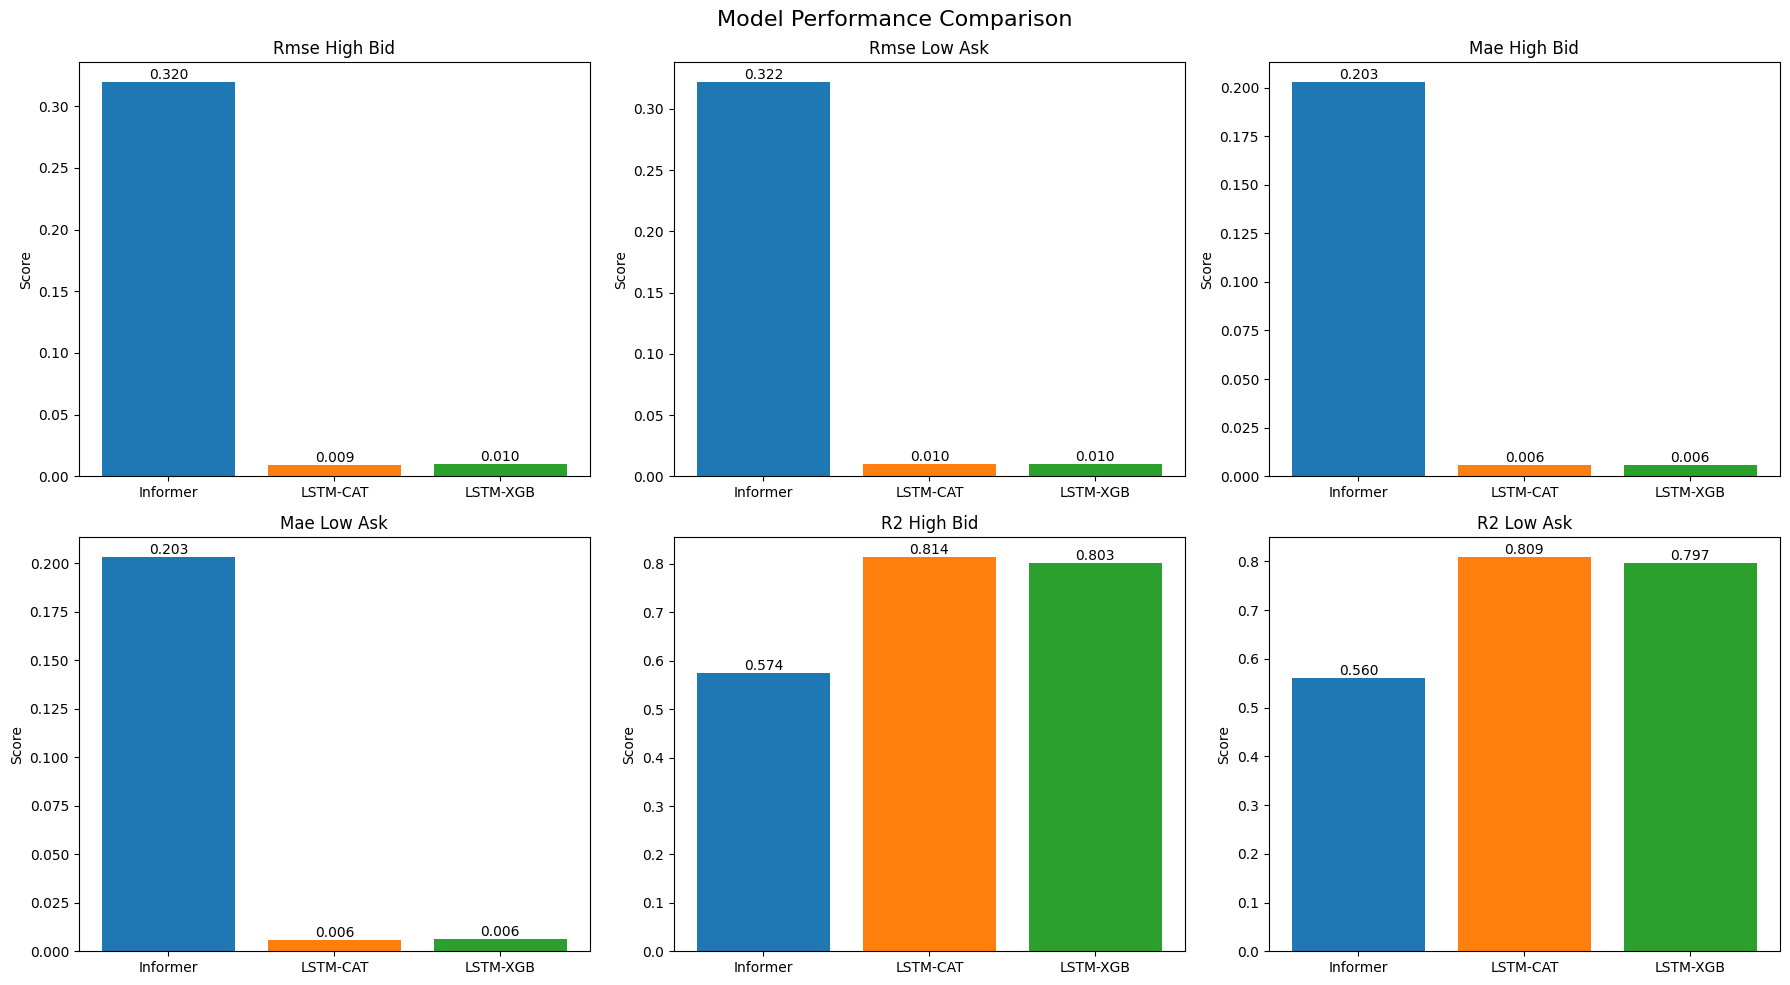

In [49]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_15min_Informer,
    'LSTM-CAT': avg_results_next_15min_LSTM_CAT,
    'LSTM-XGB': avg_results_next_15min_LSTM_XGB
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

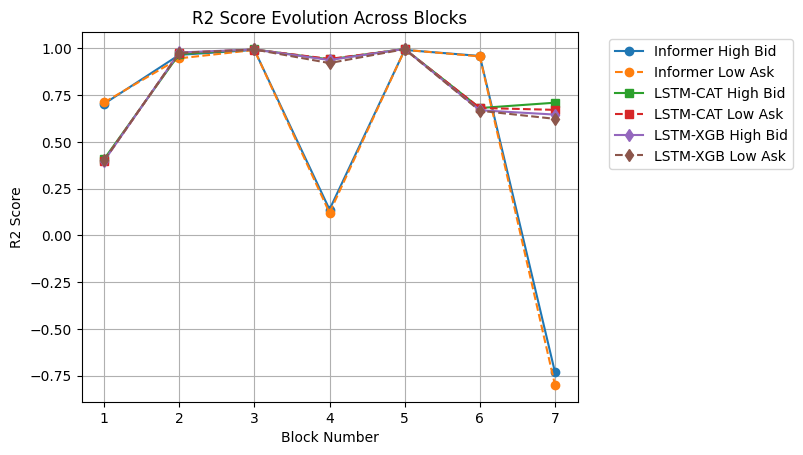

In [58]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_15min_Informer)+1)

# Plot R2 evolution
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

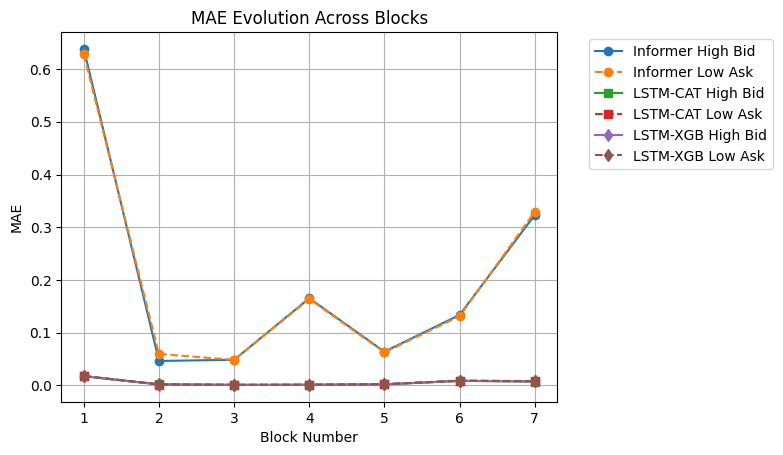

In [57]:
# Plot MAE evolution
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 30 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 30 minutes up (6 rows)

Then you need to delete the last 6 rows since there are no prices for the next 30 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 6 rows up.
'''

In [59]:
inputs_data = df_5min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(118096, 18)

In [60]:
outputs_data = df_5min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(118096, 2)

In [61]:
print(outputs_data.tail(7), '\n')
outputs_data = outputs_data.shift(-6)
print(outputs_data.tail(7))

        Y_High_BID  Y_Low_ASK
118089    3.083898   3.086702
118090    3.083898   3.086702
118091    3.083898   3.086702
118092    3.083898   3.086702
118093    3.083898   3.086702
118094    3.083898   3.086702
118095    3.083898   3.086702 

        Y_High_BID  Y_Low_ASK
118089    3.083898   3.086702
118090         NaN        NaN
118091         NaN        NaN
118092         NaN        NaN
118093         NaN        NaN
118094         NaN        NaN
118095         NaN        NaN


In [62]:
outputs_data = outputs_data.iloc[:-6]
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
118088,3.083898,3.086702
118089,3.083898,3.086702


In [63]:
inputs_data = inputs_data.iloc[:-6]
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
118088,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0
118089,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0


In [64]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (118090, 18) 
outputs Numpy array size: (118090, 2)


In [65]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 118065 25 18


In [66]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [67]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|██████████████████████████████████████████████████████████████████████| 118065/118065 [00:00<00:00, 185900.94it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [68]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (118065, 25, 18) 
outputs 2D vector size: (118065, 2)


In [69]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [70]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 7
Shape of first training block X: (16500, 25, 18)
Shape of first testing block X: (2500, 25, 18)
Shape of last training block X: (16500, 25, 18)
Shape of last testing block X: (2500, 25, 18)


In [71]:
#
# LSTM-XGBOOST model
#

In [72]:
results_next_30min_LSTM_XGB = []

In [73]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_30min_LSTM_XGB.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1056 - val_loss: 1.5351e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.2121e-05 - val_loss: 1.1924e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.8353e-05 - val_loss: 1.0743e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.2090e-05 - val_loss: 8.5668e-05
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 2.9591e-05 - val_loss: 7.8641e-05
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.6950e-05 - val_loss: 7.3548e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.2846e-05 - val_loss: 6.9529e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.9767e-05 - val_loss: 8.8470e-05
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.4143e-05 - val_loss: 6.8317e-05
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.1358e-05 - val_loss: 5.7611e-05
Epoch 11/100
413/41

In [75]:
metrics_next_30min_LSTM_XGB = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_LSTM_XGB = {metric: np.mean([r[metric] for r in results_next_30min_LSTM_XGB]) for metric in metrics_next_30min_LSTM_XGB}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_LSTM_XGB.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0104
Average rmse_low_ask: 0.0113
Average mae_high_bid: 0.0064
Average mae_low_ask: 0.0071
Average r2_high_bid: 0.7793
Average r2_low_ask: 0.7354


In [76]:
#
# LSTM-CATBOOST model
#

In [77]:
results_next_30min_LSTM_CAT = []

In [78]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_30min_LSTM_CAT.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1203 - val_loss: 6.1748e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.5524e-05 - val_loss: 2.2546e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.9536e-05 - val_loss: 1.3609e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3.4690e-05 - val_loss: 1.0948e-04
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.6050e-05 - val_loss: 1.1536e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.4105e-05 - val_loss: 1.0032e-04
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.1545e-05 - val_loss: 9.8415e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.8575e-05 - val_loss: 1.0492e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.8283e-05 - val_loss: 9.5476e-05
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.9582e-05 - val_loss: 8.5254e-05
Epoch 11/100
4

In [80]:
metrics_next_30min_LSTM_CAT = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_LSTM_CAT = {metric: np.mean([r[metric] for r in results_next_30min_LSTM_CAT]) for metric in metrics_next_30min_LSTM_CAT}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_LSTM_CAT.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0101
Average rmse_low_ask: 0.0105
Average mae_high_bid: 0.0062
Average mae_low_ask: 0.0066
Average r2_high_bid: 0.7937
Average r2_low_ask: 0.7809


In [81]:
#
# Informer model
#

In [82]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '5min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 6 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [83]:
Informer_model = Exp_Informer

In [84]:
results_next_30min_Informer = []

In [85]:
results_dir = './results'

for i in range(number_of_blocks_for_informer):
    args.data_path = f'walk_forward_data_split_informer/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_30min_Informer.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl288_ll144_pl6_dm256_nh8_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 13007
val 1895
test 3795
	iters: 100, epoch: 1 | loss: 0.2952909
	speed: 3.2882s/iter; left time: 13024.5285s
	iters: 200, epoch: 1 | loss: 0.2785594
	speed: 3.2824s/iter; left time: 12673.3908s
	iters: 300, epoch: 1 | loss: 0.1563375
	speed: 3.3399s/iter; left time: 12561.4870s
	iters: 400, epoch: 1 | loss: 0.1728825
	speed: 3.2970s/iter; left time: 12070.1712s
Epoch: 1 cost time: 1341.559654712677
Epoch: 1, Steps: 406 | Train Loss: 0.3567626 Vali Loss: 0.3788217 Test Loss: 1.1077231
Validation loss decreased (inf --> 0.378822).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1224565
	speed: 5.6058s/iter; left time: 19928.6886s
	iters: 200, epoch: 2 | loss: 0.8799350
	speed: 3.2697s/iter; left time: 11296.8133s
	iters: 300, epoch: 2 | loss: 0.1875768
	speed: 3.2916s/iter; left time: 11043.2978s
	iters: 400, ep

In [86]:
metrics_next_30min_Informer = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_Informer = {metric: np.mean([r[metric] for r in results_next_30min_Informer]) for metric in metrics_next_30min_Informer}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_Informer.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.3421
Average rmse_low_ask: 0.3346
Average mae_high_bid: 0.2255
Average mae_low_ask: 0.2162
Average r2_high_bid: 0.5838
Average r2_low_ask: 0.6190


In [ ]:
#
# Visualisation
#

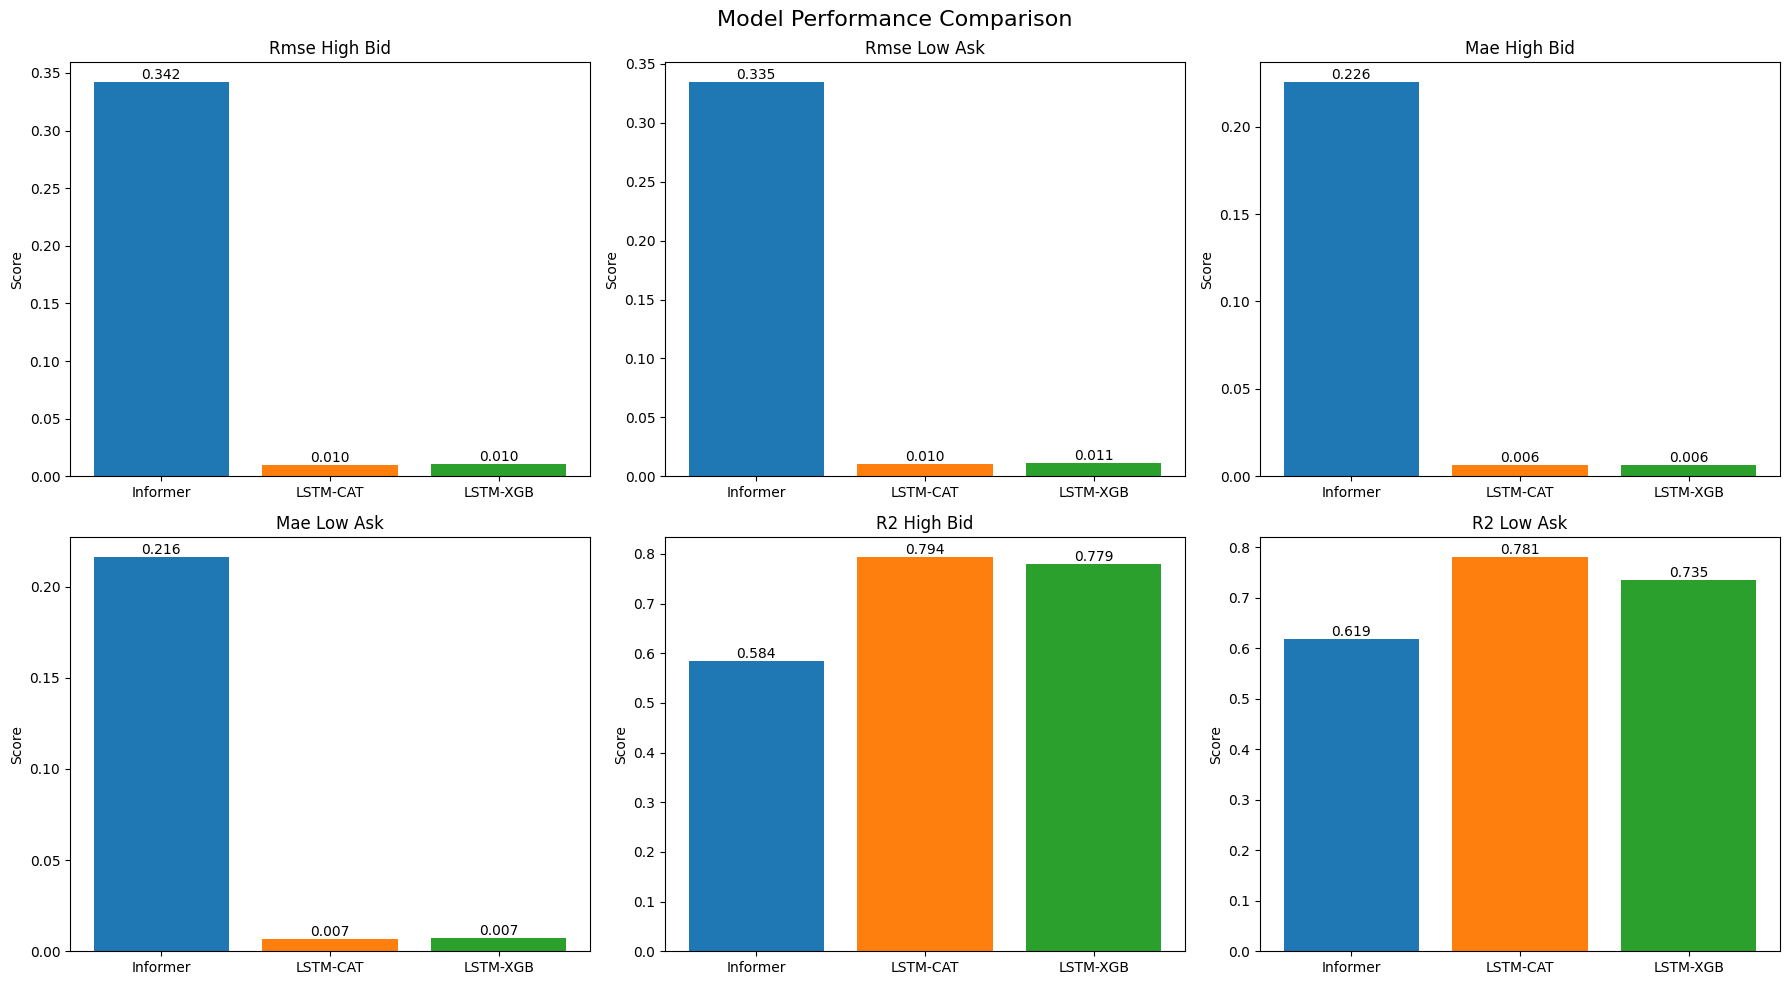

In [87]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_30min_Informer,
    'LSTM-CAT': avg_results_next_30min_LSTM_CAT,
    'LSTM-XGB': avg_results_next_30min_LSTM_XGB
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

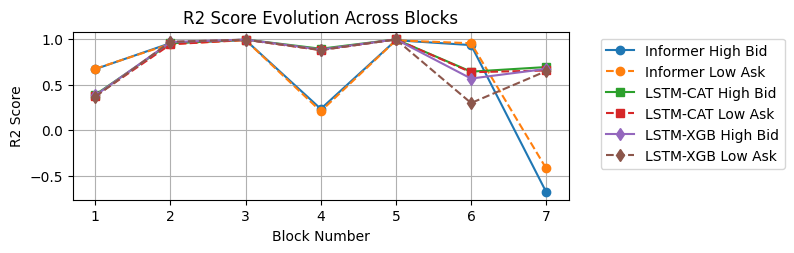

In [88]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_15min_Informer)+1)

# Plot R2 evolution
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

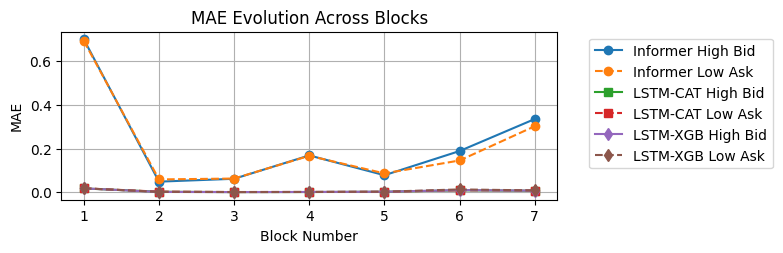

In [89]:
# Plot MAE evolution
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [11]:
'''
We will predict the Highest and Lowest prices for the next 60 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (12 rows)

Then you need to delete the last 12 rows since there are no prices for the next 60 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 12 rows up.
'''

'\nWe will predict the Highest and Lowest prices for the next 60 minutes.\n\nTo do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (12 rows)\n\nThen you need to delete the last 12 rows since there are no prices for the next 60 minutes.\n\nTherefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 12 rows up.\n'

In [12]:
inputs_data = df_5min.drop(['date', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(118096, 18)

In [13]:
outputs_data = df_5min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(118096, 2)

In [14]:
print(outputs_data.tail(12), '\n')
outputs_data = outputs_data.shift(-12)
print(outputs_data.tail(12))

        Y_High_BID  Y_Low_ASK
118084    3.083898   3.086702
118085    3.083898   3.086702
118086    3.083898   3.086702
118087    3.083898   3.086702
118088    3.083898   3.086702
118089    3.083898   3.086702
118090    3.083898   3.086702
118091    3.083898   3.086702
118092    3.083898   3.086702
118093    3.083898   3.086702
118094    3.083898   3.086702
118095    3.083898   3.086702 

        Y_High_BID  Y_Low_ASK
118084         NaN        NaN
118085         NaN        NaN
118086         NaN        NaN
118087         NaN        NaN
118088         NaN        NaN
118089         NaN        NaN
118090         NaN        NaN
118091         NaN        NaN
118092         NaN        NaN
118093         NaN        NaN
118094         NaN        NaN
118095         NaN        NaN


In [15]:
outputs_data = outputs_data.iloc[:-12]
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
118082,3.083898,3.086702
118083,3.083898,3.086702


In [16]:
inputs_data = inputs_data.iloc[:-12]
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
118082,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0
118083,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.363128,0.0,2.804,2.804,2.804,2.804,0,0


In [17]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (118084, 18) 
outputs Numpy array size: (118084, 2)


In [18]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 118059 25 18


In [19]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [20]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|██████████████████████████████████████████████████████████████████████| 118059/118059 [00:00<00:00, 212133.48it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [21]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (118059, 25, 18) 
outputs 2D vector size: (118059, 2)


In [28]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [29]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 7
Shape of first training block X: (16500, 25, 18)
Shape of first testing block X: (2500, 25, 18)
Shape of last training block X: (16500, 25, 18)
Shape of last testing block X: (2500, 25, 18)


In [32]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer}")

Number of walk-forward blocks for training Informer: 7


In [33]:
#
# LSTM-XGBOOST model
#

In [34]:
results_next_60min_LSTM_XGB = []

In [35]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_XGB.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1188 - val_loss: 2.5678e-04
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.8116e-04 - val_loss: 2.0351e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.4384e-04 - val_loss: 1.1255e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.0695e-04 - val_loss: 1.0017e-04
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.9737e-05 - val_loss: 2.6340e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.8852e-05 - val_loss: 9.7539e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.6171e-05 - val_loss: 1.2769e-04
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.4139e-05 - val_loss: 1.9706e-04
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3.3868e-05 - val_loss: 3.1810e-04
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.7205e-05 - val_loss: 4.8108e-04
Epoch 11/100
413/4

In [37]:
metrics_next_60min_LSTM_XGB = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_XGB = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_XGB]) for metric in metrics_next_60min_LSTM_XGB}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_XGB.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0122
Average rmse_low_ask: 0.0125
Average mae_high_bid: 0.0079
Average mae_low_ask: 0.0080
Average r2_high_bid: 0.7100
Average r2_low_ask: 0.6938


In [38]:
#
# LSTM-CATBOOST model
#

In [39]:
results_next_60min_LSTM_CAT = []

In [40]:
'''LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(N, data_in.shape[2])),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(32),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2)
])'''
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_CAT.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.2239 - val_loss: 7.9866e-05
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8.2773e-05 - val_loss: 1.0386e-04
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.1105e-05 - val_loss: 1.0303e-04
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.2810e-05 - val_loss: 9.8836e-05
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.0858e-05 - val_loss: 1.2327e-04
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.7661e-05 - val_loss: 6.2304e-05
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.0588e-05 - val_loss: 8.2087e-05
Epoch 8/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.1635e-05 - val_loss: 7.9514e-05
Epoch 9/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 2.2459e-05 - val_loss: 6.8772e-05
Epoch 10/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.9050e-05 - val_loss: 8.3836e-05
Epoch 11/100
413/41

In [42]:
metrics_next_60min_LSTM_CAT = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_CAT = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_CAT]) for metric in metrics_next_60min_LSTM_CAT}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_CAT.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0120
Average rmse_low_ask: 0.0122
Average mae_high_bid: 0.0079
Average mae_low_ask: 0.0080
Average r2_high_bid: 0.7157
Average r2_low_ask: 0.7067


In [43]:
#
# Informer model
#

In [44]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '5min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 12 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 256 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [45]:
Informer_model = Exp_Informer

In [46]:
results_next_60min_Informer = []

In [47]:
results_dir = './results'

for i in range(number_of_blocks_for_informer):
    args.data_path = f'walk_forward_data_split_informer/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_60min_Informer.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl288_ll144_pl12_dm256_nh8_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 13001
val 1889
test 3789
	iters: 100, epoch: 1 | loss: 0.2484927
	speed: 3.3150s/iter; left time: 13130.5539s
	iters: 200, epoch: 1 | loss: 0.2470320
	speed: 3.2597s/iter; left time: 12585.8583s
	iters: 300, epoch: 1 | loss: 0.2072832
	speed: 3.2509s/iter; left time: 12226.5975s
	iters: 400, epoch: 1 | loss: 0.6216202
	speed: 3.2446s/iter; left time: 11878.3744s
Epoch: 1 cost time: 1321.5200595855713
Epoch: 1, Steps: 406 | Train Loss: 0.3646227 Vali Loss: 0.3924667 Test Loss: 1.0861746
Validation loss decreased (inf --> 0.392467).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.2383357
	speed: 5.5158s/iter; left time: 19608.5842s
	iters: 200, epoch: 2 | loss: 0.5557006
	speed: 3.2506s/iter; left time: 11230.8962s
	iters: 300, epoch: 2 | loss: 0.3447479
	speed: 3.2754s/iter; left time: 10988.8909s
	iters: 400, 

In [48]:
metrics_next_60min_Informer = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_Informer = {metric: np.mean([r[metric] for r in results_next_60min_Informer]) for metric in metrics_next_60min_Informer}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_Informer.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.3495
Average rmse_low_ask: 0.3510
Average mae_high_bid: 0.2312
Average mae_low_ask: 0.2334
Average r2_high_bid: 0.5202
Average r2_low_ask: 0.4907


In [49]:
#
# Visualisation
#

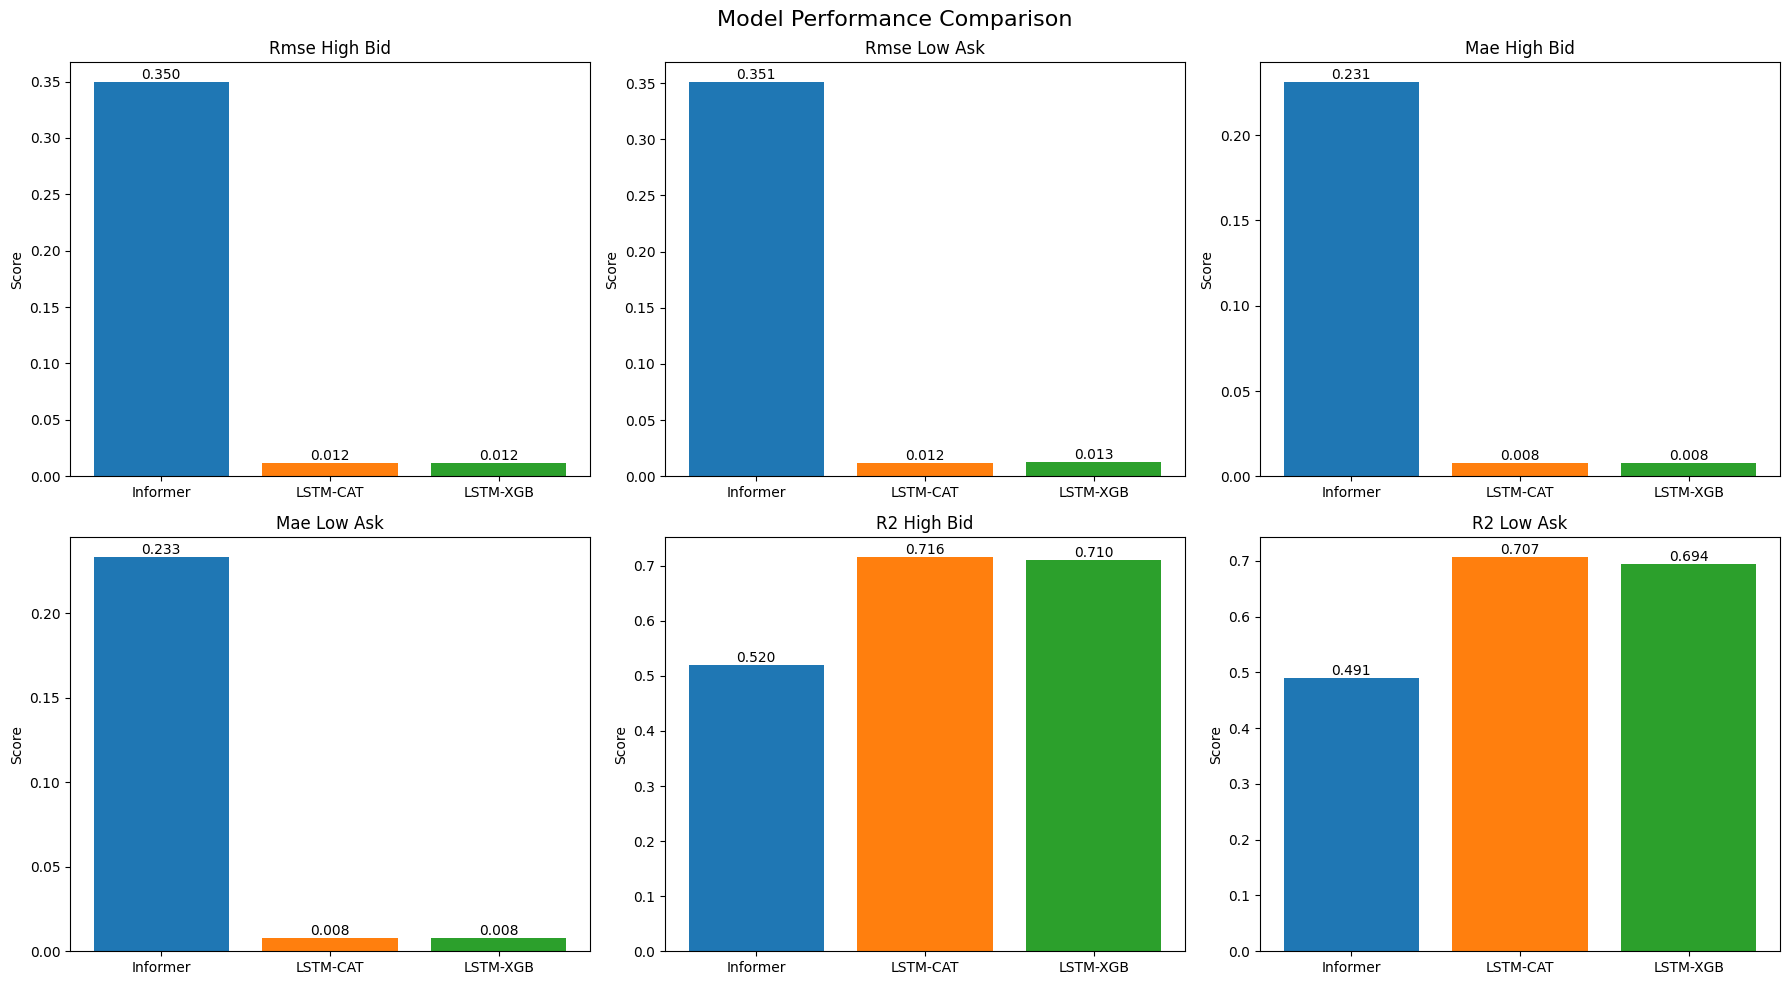

In [50]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_60min_Informer,
    'LSTM-CAT': avg_results_next_60min_LSTM_CAT,
    'LSTM-XGB': avg_results_next_60min_LSTM_XGB
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

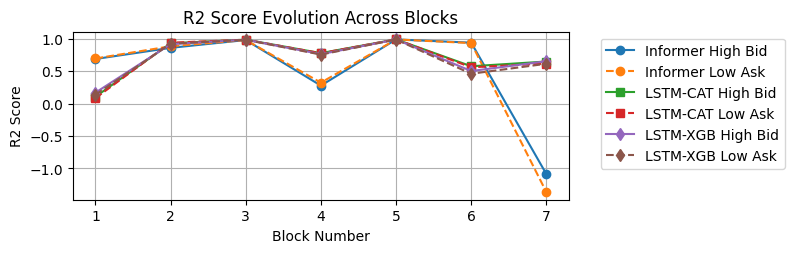

In [52]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_60min_Informer)+1)

# Plot R2 evolution
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

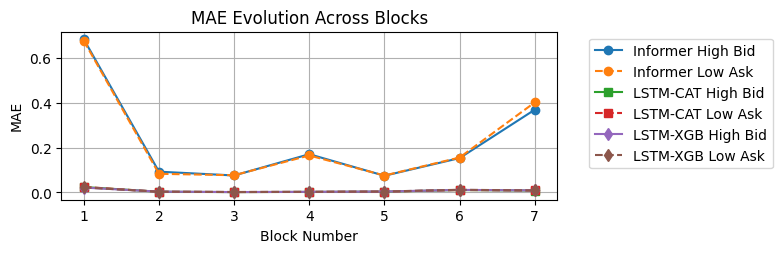

In [53]:
# Plot MAE evolution
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_Informer], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_Informer], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_CAT], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_CAT], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_XGB], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_XGB], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [304]:
#
#
#
# 15 min df
#
#
#

In [305]:
df_15min = pd.read_csv('cleaned_XAUUSD_15_M_01.01.2024-29.03.2025.csv', low_memory=False, sep=',')
df_15min.head()

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Local_Time,Open_BID,High_BID,Low_BID,Close_BID,...,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,Y_High_BID,Y_Low_ASK,New_Day,New_Week
0,2.063112,2.063112,2.063112,2.063112,0.0,2024-01-01 00:00:00+00:00,2.062688,2.062688,2.062688,2.062688,...,0.619742,0.0,0.424,0.424,0.424,0.424,2.062688,2.063112,0,0
1,2.063112,2.063112,2.063112,2.063112,0.0,2024-01-01 00:15:00+00:00,2.062688,2.062688,2.062688,2.062688,...,0.619742,0.0,0.424,0.424,0.424,0.424,2.062688,2.063112,0,0
2,2.063112,2.063112,2.063112,2.063112,0.0,2024-01-01 00:30:00+00:00,2.062688,2.062688,2.062688,2.062688,...,0.619742,0.0,0.424,0.424,0.424,0.424,2.062688,2.063112,0,0
3,2.063112,2.063112,2.063112,2.063112,0.0,2024-01-01 00:45:00+00:00,2.062688,2.062688,2.062688,2.062688,...,0.619742,0.0,0.424,0.424,0.424,0.424,2.062688,2.063112,0,0
4,2.063112,2.063112,2.063112,2.063112,0.0,2024-01-01 01:00:00+00:00,2.062688,2.062688,2.062688,2.062688,...,0.619742,0.0,0.424,0.424,0.424,0.424,2.062688,2.063112,0,0


In [306]:
df_15min_informer = pd.read_csv('cleaned_XAUUSD_15_M_01.01.2024-29.03.2025_for_informer.csv', low_memory=False, sep=',')
df_15min_informer.iloc[5000:5007]

,date,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
5000,2024-02-22 02:00:00+00:00,2.027225,2.028622,2.026735,2.027515,0.086265,2.026925,2.028295,2.026445,2.027155,0.029899,0.662716,0.069342,0.300,0.327,0.29,0.360,0,0
5001,2024-02-22 02:15:00+00:00,2.027545,2.028015,2.026785,2.027135,0.018995,2.027195,2.027725,2.026475,2.026845,0.021641,0.617724,0.003256,0.350,0.290,0.31,0.290,0,0
5002,2024-02-22 02:30:00+00:00,2.027105,2.027455,2.026815,2.027445,0.009044,2.026815,2.027155,2.026525,2.027085,0.007150,0.621186,0.002330,0.290,0.300,0.29,0.360,0,0
5003,2024-02-22 02:45:00+00:00,2.027426,2.028545,2.027425,2.027975,0.015257,2.027085,2.028235,2.027085,2.027638,0.014648,0.620207,0.000750,0.341,0.310,0.34,0.337,0,0
5004,2024-02-22 03:00:00+00:00,2.027925,2.028525,2.027325,2.027455,0.012988,2.027638,2.028215,2.027035,2.027135,0.009059,0.622738,0.004833,0.287,0.310,0.29,0.320,0,0
5005,2024-02-22 03:15:00+00:00,2.027405,2.027502,2.026975,2.027035,0.021879,2.027085,2.027185,2.026675,2.026735,0.008961,0.629591,0.015893,0.320,0.317,0.30,0.300,0,0
5006,2024-02-22 03:30:00+00:00,2.027025,2.027215,2.026635,2.026902,0.010195,2.026725,2.026905,2.026325,2.026615,0.005391,0.623404,0.005909,0.300,0.310,0.31,0.287,0,0


In [307]:
'''
We will predict the Highest and Lowest prices for the next 15 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 15 minutes up (1 row)

Then you need to delete the last row since there are no prices for the next 15 minutes.
Therefore, we will create an array of answers "data_ay" with the 
Highest and Lowest prices shifted sequentially to 1 row up.
'''

'\nWe will predict the Highest and Lowest prices for the next 15 minutes.\n\nTo do this in the data output (vector of answers), we shift prices sequentially to 15 minutes up (1 row)\n\nThen you need to delete the last row since there are no prices for the next 15 minutes.\nTherefore, we will create an array of answers "data_ay" with the \nHighest and Lowest prices shifted sequentially to 1 row up.\n'

In [308]:
inputs_data = df_15min.drop(['Local_Time', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(43584, 18)

In [309]:
outputs_data = df_15min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(43584, 2)

In [310]:
print(outputs_data.tail(2), '\n')
outputs_data = outputs_data.shift(-1)
print(outputs_data.tail(2))

       Y_High_BID  Y_Low_ASK
43582    3.083898   3.086702
43583    3.083898   3.086702 

       Y_High_BID  Y_Low_ASK
43582    3.083898   3.086702
43583         NaN        NaN


In [311]:
outputs_data.drop(outputs_data.shape[0]-1, axis=0, inplace=True)
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
43581,3.083898,3.086702
43582,3.083898,3.086702


In [312]:
inputs_data.drop(inputs_data.shape[0]-1, axis=0, inplace=True)
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
43581,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.619742,0.0,2.804,2.804,2.804,2.804,0,0
43582,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.619742,0.0,2.804,2.804,2.804,2.804,0,0


In [313]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (43583, 18) 
outputs Numpy array size: (43583, 2)


In [314]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 43558 25 18


In [315]:
# create inputs zeros 3D tensors with 'float32'
data_in = np.zeros( (L, N, t), dtype= 'float32' )

# create a 2D zeros vector of answers
data_out = np.zeros((L, 2), dtype= 'float32')

In [316]:
# fill the inputs 3D tensor (data_in)
# and the array of answers data_out

for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]   # normalised Y_High_Bid - max 10 minutes future price
    data_out[k,1] = data_y[k+N-1,1]   # normalised Y_Low_Ask -  min 10 minutes future price

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|████████████████████████████████████████████████████████████████████████| 43558/43558 [00:00<00:00, 245380.69it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [317]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (43558, 25, 18) 
outputs 2D vector size: (43558, 2)


In [318]:
train_size, test_size = 10000, 2000

In [319]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [320]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 4
Shape of first training block X: (10000, 25, 18)
Shape of first testing block X: (2000, 25, 18)
Shape of last training block X: (10000, 25, 18)
Shape of last testing block X: (2000, 25, 18)


In [321]:
number_of_blocks_for_informer_15minDF = walk_forward_split_for_informer(df_15min_informer, './walk_forward_data_split_informer_15minDF', train_size, test_size)

Start: 0 | End Train: 10000 | End Test: 12000
Block 0 | Rows: 12000 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_0.csv
Start: 10000 | End Train: 20000 | End Test: 22000
Block 1 | Rows: 12000 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_1.csv
Start: 20000 | End Train: 30000 | End Test: 32000
Block 2 | Rows: 12000 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_2.csv
Start: 30000 | End Train: 40000 | End Test: 42000
Block 3 | Rows: 12000 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_3.csv


In [322]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer_15minDF}")

Number of walk-forward blocks for training Informer: 4


In [323]:
#
# LSTM-XGBOOST model
#

In [324]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [325]:
results_next_15min_LSTM_XGB_15minDF = []

In [326]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_15min_LSTM_XGB_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.4424 - val_loss: 0.0067
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.4346e-04 - val_loss: 0.0035
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2147e-04 - val_loss: 0.0035
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2786e-04 - val_loss: 0.0012
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.4584e-05 - val_loss: 0.0011
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0174e-05 - val_loss: 0.0017
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.7785e-05 - val_loss: 0.0020
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.4321e-05 - val_loss: 0.0014
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.8218e-05 - val_loss: 0.0012
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.5194e-05 - val_loss: 0.0014
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 

In [327]:
metrics_next_15min_LSTM_XGB_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_LSTM_XGB_15minDF = {metric: np.mean([r[metric] for r in results_next_15min_LSTM_XGB_15minDF]) for metric in metrics_next_15min_LSTM_XGB_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_LSTM_XGB_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0084
Average rmse_low_ask: 0.0094
Average mae_high_bid: 0.0060
Average mae_low_ask: 0.0065
Average r2_high_bid: 0.8835
Average r2_low_ask: 0.8726


In [328]:
#
# LSTM-CATBOOST model
#

In [329]:
results_next_15min_LSTM_CAT_15minDF = []

In [330]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])
LSTM_model_for_cat.summary()
LSTM_model_for_cat.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [331]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_15min_LSTM_CAT_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1253 - val_loss: 9.8830e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.5768e-04 - val_loss: 0.0012
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.9060e-05 - val_loss: 8.0709e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.9663e-05 - val_loss: 0.0011
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.4779e-05 - val_loss: 8.5356e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6914e-05 - val_loss: 8.8481e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.3202e-05 - val_loss: 7.5100e-04
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8440e-05 - val_loss: 7.8686e-04
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.5914e-05 - val_loss: 8.1048e-04
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.8669e-05 - val_loss: 8.1658e-04
Epoch 11/100
250/250 ━━━━━━━━

In [332]:
metrics_next_15min_LSTM_CAT_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_LSTM_CAT_15minDF = {metric: np.mean([r[metric] for r in results_next_15min_LSTM_CAT_15minDF]) for metric in metrics_next_15min_LSTM_CAT_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_LSTM_CAT_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0051
Average rmse_low_ask: 0.0051
Average mae_high_bid: 0.0032
Average mae_low_ask: 0.0031
Average r2_high_bid: 0.9703
Average r2_low_ask: 0.9714


In [11]:
#
# Informer model
#

In [340]:
train_size, test_size = 8200, 1200
number_of_blocks_for_informer_15minDF = walk_forward_split_for_informer(df_15min_informer, './walk_forward_data_split_informer_15minDF', train_size, test_size)

Start: 0 | End Train: 8200 | End Test: 9400
Block 0 | Rows: 9400 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_0.csv
Start: 8200 | End Train: 16400 | End Test: 17600
Block 1 | Rows: 9400 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_1.csv
Start: 16400 | End Train: 24600 | End Test: 25800
Block 2 | Rows: 9400 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_2.csv
Start: 24600 | End Train: 32800 | End Test: 34000
Block 3 | Rows: 9400 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_3.csv
Start: 32800 | End Train: 41000 | End Test: 42200
Block 4 | Rows: 9400 | Columns: 19 | Path: ./walk_forward_data_split_informer_15minDF\walk_forward_block_4.csv


In [345]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '15min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 4 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 1024 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 15
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [346]:
Informer_model = Exp_Informer

In [347]:
results_next_15min_Informer_15minDF = []

In [348]:
results_dir = './results'

for i in range(number_of_blocks_for_informer_15minDF-1):
    args.data_path = f'walk_forward_data_split_informer_15minDF/walk_forward_block_{i+1}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, (i+1), args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_15min_Informer_15minDF.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk1_ftM_sl96_ll48_pl1_dm512_nh4_el2_dl1_df1024_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 6484
val 940
test 1880
	iters: 100, epoch: 1 | loss: 0.1744382
	speed: 1.9500s/iter; left time: 5715.5315s
	iters: 200, epoch: 1 | loss: 0.2697757
	speed: 1.9719s/iter; left time: 5582.4025s
Epoch: 1 cost time: 396.7008788585663
Epoch: 1, Steps: 202 | Train Loss: 0.3246321 Vali Loss: 0.2712125 Test Loss: 0.2208889
Validation loss decreased (inf --> 0.271212).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.0794646
	speed: 2.5349s/iter; left time: 6917.7581s
	iters: 200, epoch: 2 | loss: 0.3788913
	speed: 1.9128s/iter; left time: 5028.7690s
Epoch: 2 cost time: 392.86701798439026
Epoch: 2, Steps: 202 | Train Loss: 0.2453936 Vali Loss: 0.2554543 Test Loss: 0.2109906
Validation loss decreased (0.271212 --> 0.255454).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.1051926
	speed: 2.5

In [349]:
metrics_next_15min_Informer_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_15min_Informer_15minDF = {metric: np.mean([r[metric] for r in results_next_15min_Informer_15minDF]) for metric in metrics_next_15min_Informer_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_15min_Informer_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.1670
Average rmse_low_ask: 0.1743
Average mae_high_bid: 0.1222
Average mae_low_ask: 0.1280
Average r2_high_bid: 0.8902
Average r2_low_ask: 0.8819


In [350]:
#
# Visualisation
#

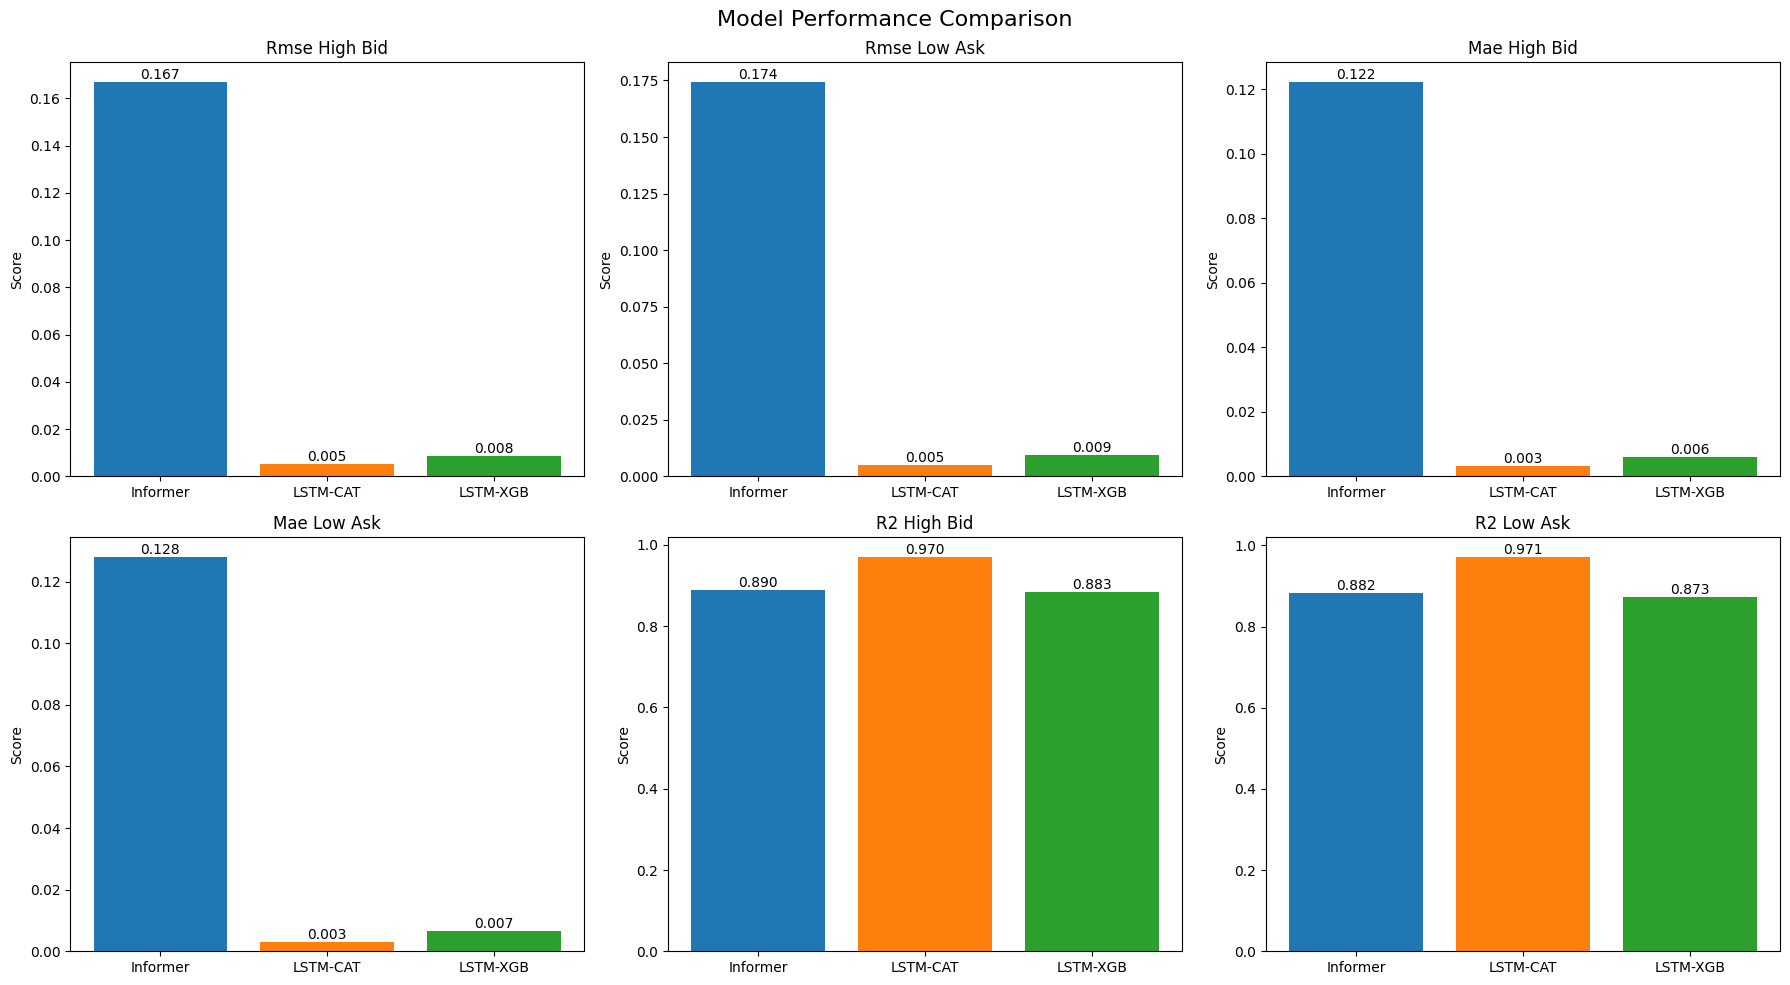

In [351]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_15min_Informer_15minDF,
    'LSTM-CAT': avg_results_next_15min_LSTM_CAT_15minDF,
    'LSTM-XGB': avg_results_next_15min_LSTM_XGB_15minDF
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

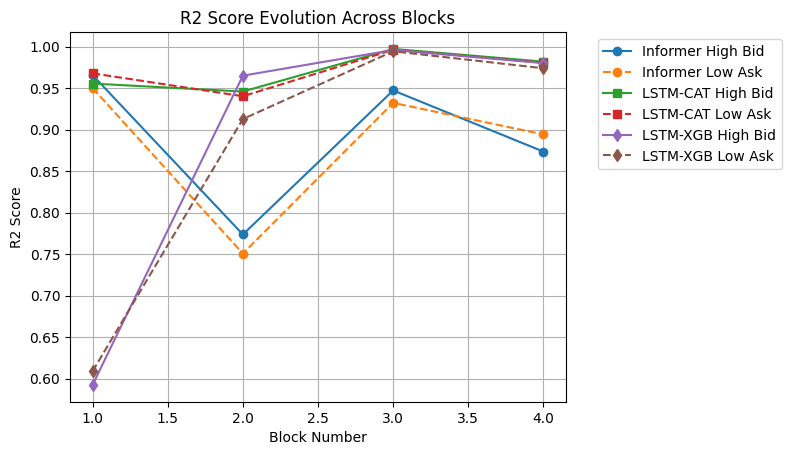

In [352]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_15min_Informer_15minDF)+1)

# Plot R2 evolution
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_15min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_15min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

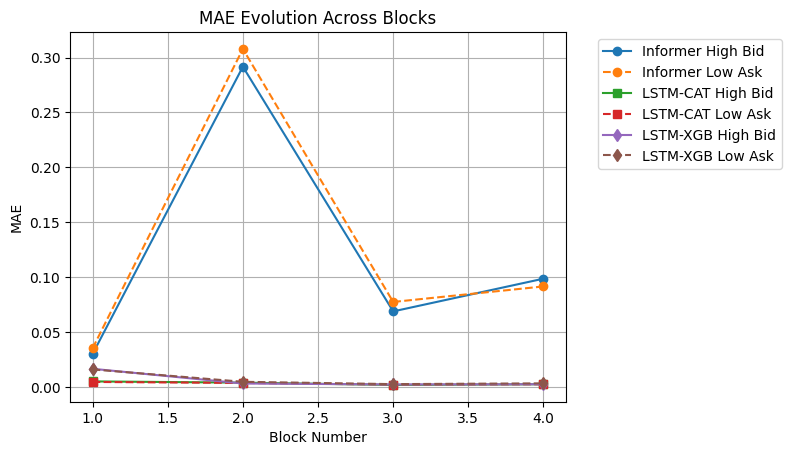

In [353]:
# Plot MAE evolution
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_15min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_15min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 30 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 30 minutes up (2 rows)

Then you need to delete the last 2 rows since there are no prices for the next 30 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 2 rows up.
'''

In [13]:
inputs_data = df_15min.drop(['Local_Time', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(43584, 18)

In [14]:
outputs_data = df_15min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(43584, 2)

In [15]:
print(outputs_data.tail(3), '\n')
outputs_data = outputs_data.shift(-2)
print(outputs_data.tail(3))

       Y_High_BID  Y_Low_ASK
43581    3.083898   3.086702
43582    3.083898   3.086702
43583    3.083898   3.086702 

       Y_High_BID  Y_Low_ASK
43581    3.083898   3.086702
43582         NaN        NaN
43583         NaN        NaN


In [16]:
outputs_data = outputs_data.iloc[:-2]
outputs_data.tail(3)

,Y_High_BID,Y_Low_ASK
43579,3.083898,3.086702
43580,3.083898,3.086702
43581,3.083898,3.086702


In [17]:
inputs_data = inputs_data.iloc[:-2]
inputs_data.tail(3)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
43579,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.619742,0.0,2.804,2.804,2.804,2.804,0,0
43580,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.619742,0.0,2.804,2.804,2.804,2.804,0,0
43581,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.619742,0.0,2.804,2.804,2.804,2.804,0,0


In [18]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (43582, 18) 
outputs Numpy array size: (43582, 2)


In [19]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 43557 25 18


In [20]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [21]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|████████████████████████████████████████████████████████████████████████| 43557/43557 [00:00<00:00, 152036.11it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [22]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (43557, 25, 18) 
outputs 2D vector size: (43557, 2)


In [24]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [25]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 4
Shape of first training block X: (10000, 25, 18)
Shape of first testing block X: (2000, 25, 18)
Shape of last training block X: (10000, 25, 18)
Shape of last testing block X: (2000, 25, 18)


In [22]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer_15minDF}")

Number of walk-forward blocks for training Informer: 4


In [26]:
#
# LSTM-XGBOOST model
#

In [27]:
results_next_30min_LSTM_XGB_15minDF = []

In [28]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_30min_LSTM_XGB_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.2525 - val_loss: 0.0576
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0013 - val_loss: 0.0288
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.2566e-04 - val_loss: 0.0138
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.8222e-04 - val_loss: 0.0084
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.2819e-04 - val_loss: 0.0050
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 6.8733e-05 - val_loss: 0.0032
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.4855e-05 - val_loss: 0.0031
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 5.7193e-05 - val_loss: 0.0028
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 4.1877e-05 - val_loss: 0.0028
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 3.9666e-05 - val_loss: 0.0025
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step -

In [30]:
metrics_next_30min_LSTM_XGB_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_LSTM_XGB_15minDF = {metric: np.mean([r[metric] for r in results_next_30min_LSTM_XGB_15minDF]) for metric in metrics_next_30min_LSTM_XGB_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_LSTM_XGB_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0079
Average rmse_low_ask: 0.0078
Average mae_high_bid: 0.0055
Average mae_low_ask: 0.0051
Average r2_high_bid: 0.9328
Average r2_low_ask: 0.9337


In [31]:
#
# LSTM-CATBOOST model
#

In [32]:
results_next_30min_LSTM_CAT_15minDF = []

In [33]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_30min_LSTM_CAT_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.2156 - val_loss: 0.0031
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 1.5005e-04 - val_loss: 0.0024
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 8.8773e-05 - val_loss: 0.0019
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 7.4728e-05 - val_loss: 0.0015
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 4.9863e-05 - val_loss: 0.0013
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 4.4905e-05 - val_loss: 9.2151e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3.3141e-05 - val_loss: 0.0015
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 4.2055e-05 - val_loss: 9.9371e-04
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3.4878e-05 - val_loss: 9.7743e-04
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.6645e-05 - val_loss: 0.0014
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━

In [35]:
metrics_next_30min_LSTM_CAT_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_LSTM_CAT_15minDF = {metric: np.mean([r[metric] for r in results_next_30min_LSTM_CAT_15minDF]) for metric in metrics_next_30min_LSTM_CAT_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_LSTM_CAT_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0099
Average rmse_low_ask: 0.0100
Average mae_high_bid: 0.0070
Average mae_low_ask: 0.0067
Average r2_high_bid: 0.8598
Average r2_low_ask: 0.8523


In [33]:
#
# Informer model
#

In [8]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '15min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 2 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 4 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 512 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [9]:
Informer_model = Exp_Informer

In [10]:
results_next_30min_Informer_15minDF = []

In [11]:
results_dir = './results'

for i in range(number_of_blocks_for_informer_15minDF):
    args.data_path = f'walk_forward_data_split_informer_15minDF/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_30min_Informer_15minDF.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk1_ftM_sl288_ll144_pl2_dm512_nh4_el2_dl1_df512_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 5311
val 799
test 1599
	iters: 100, epoch: 1 | loss: 0.2421444
	speed: 5.4324s/iter; left time: 8425.7100s
Epoch: 1 cost time: 892.0444231033325
Epoch: 1, Steps: 165 | Train Loss: 0.4032602 Vali Loss: 0.2138888 Test Loss: 0.3093234
Validation loss decreased (inf --> 0.213889).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1135367
	speed: 10.6017s/iter; left time: 14693.9197s
Epoch: 2 cost time: 907.7292907238007
Epoch: 2, Steps: 165 | Train Loss: 0.2800745 Vali Loss: 0.2085091 Test Loss: 0.2656513
Validation loss decreased (0.213889 --> 0.208509).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.8049932
	speed: 10.6372s/iter; left time: 12988.0195s
Epoch: 3 cost time: 905.5157299041748
Epoch: 3, Steps: 165 | Train Loss: 0.2569188 Vali Loss: 0.1729078 Test Loss: 0.2593110
Valida

In [12]:
metrics_next_30min_Informer_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_30min_Informer_15minDF = {metric: np.mean([r[metric] for r in results_next_30min_Informer_15minDF]) for metric in metrics_next_30min_Informer_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_30min_Informer_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.2414
Average rmse_low_ask: 0.2367
Average mae_high_bid: 0.1919
Average mae_low_ask: 0.1867
Average r2_high_bid: 0.6162
Average r2_low_ask: 0.6557


In [ ]:
#
# Visualisation
#

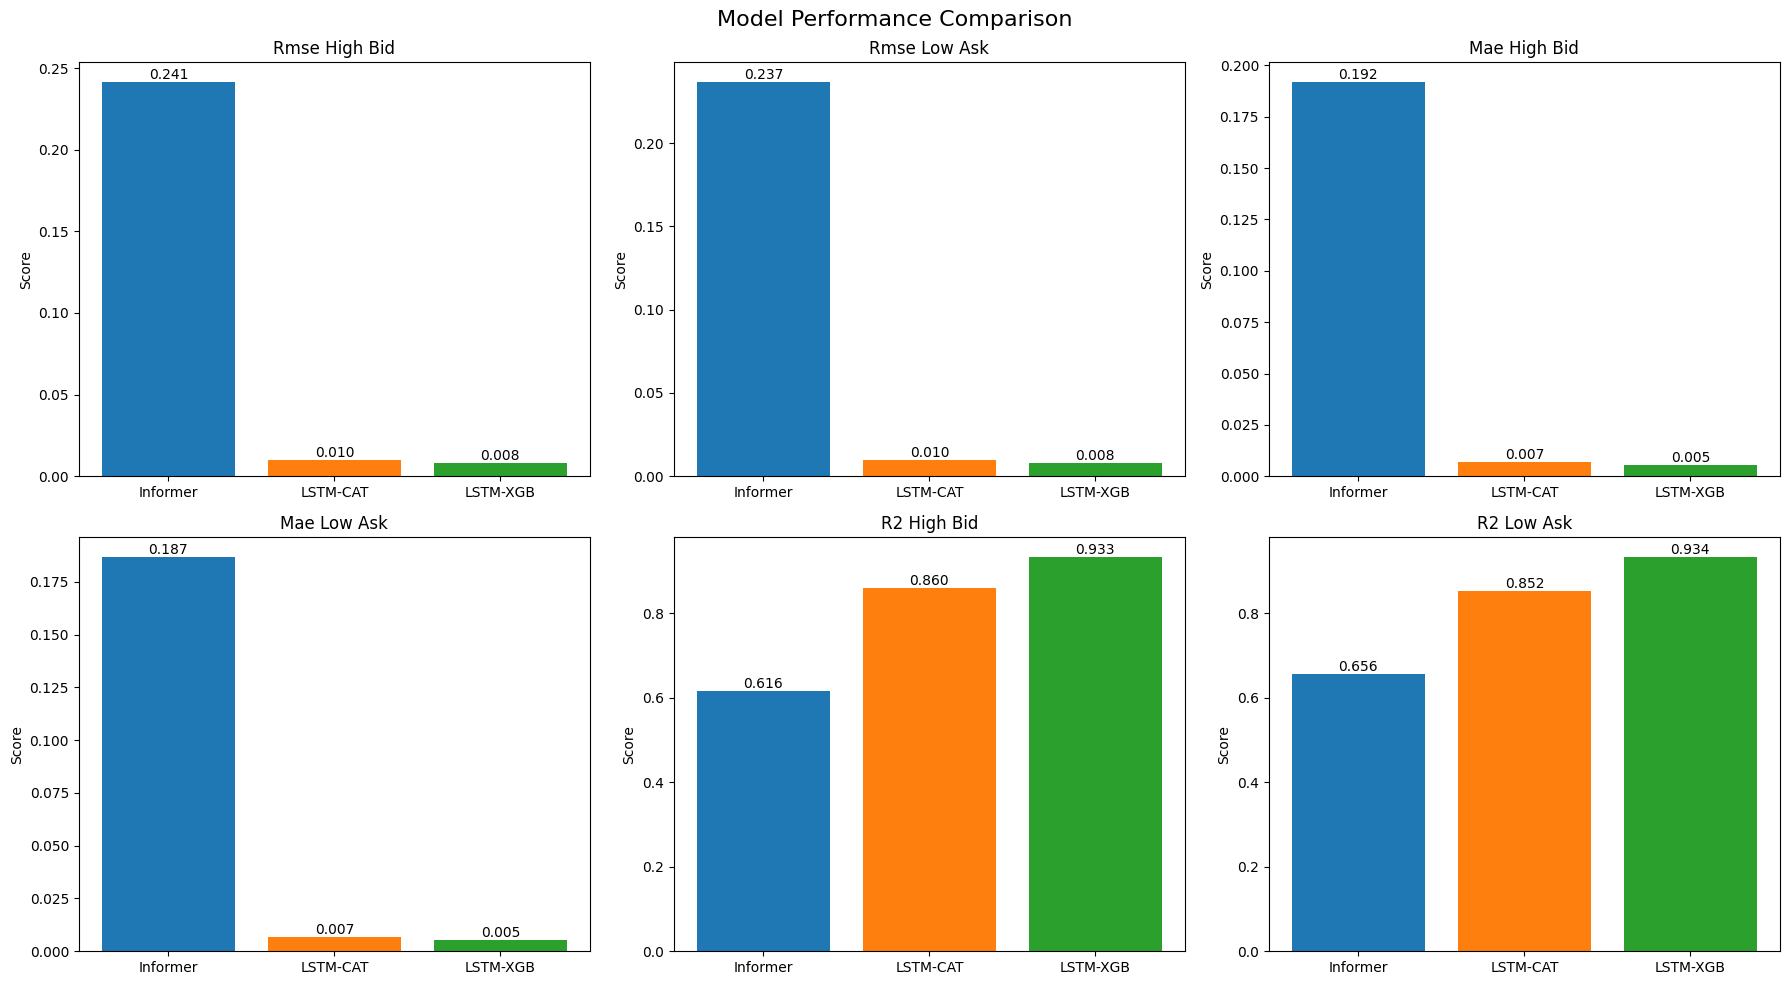

In [36]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_30min_Informer_15minDF,
    'LSTM-CAT': avg_results_next_30min_LSTM_CAT_15minDF,
    'LSTM-XGB': avg_results_next_30min_LSTM_XGB_15minDF
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

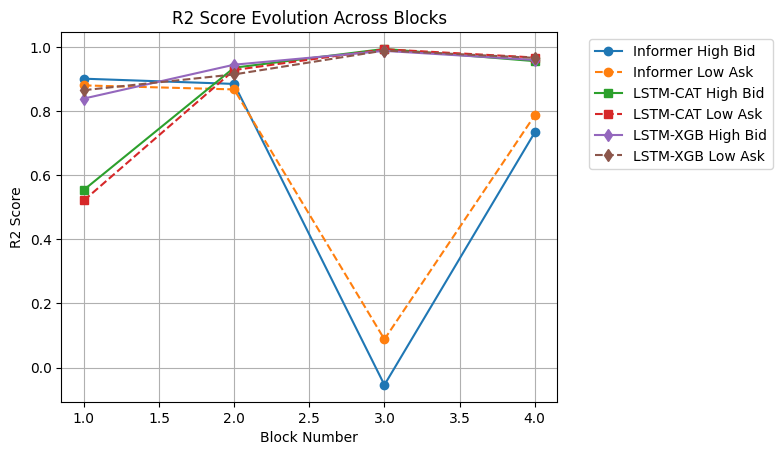

In [38]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_30min_Informer_15minDF)+1)

# Plot R2 evolution
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_30min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_30min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

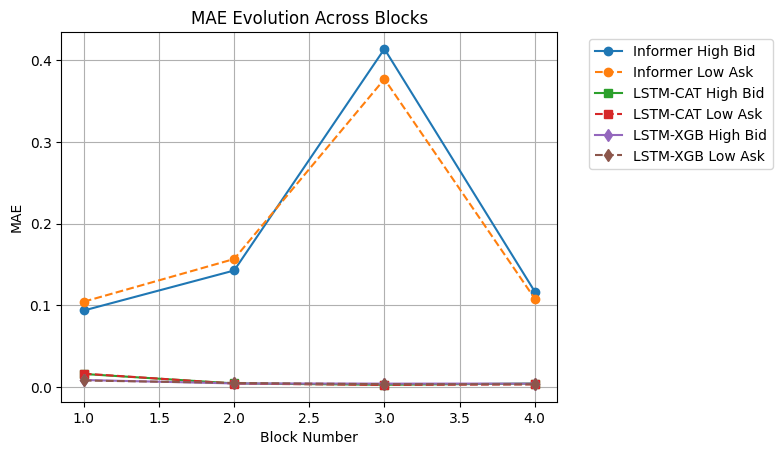

In [39]:
# Plot MAE evolution
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_30min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_30min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
'''
We will predict the Highest and Lowest prices for the next 60 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (4 rows)

Then you need to delete the last 4 rows since there are no prices for the next 60 minutes.

Therefore, we will create an array of answers "data_ay" with the Highest and Lowest prices shifted sequentially to 4 rows up.
'''

In [10]:
inputs_data = df_15min.drop(['Local_Time', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(43584, 18)

In [11]:
outputs_data = df_15min[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(43584, 2)

In [12]:
print(outputs_data.tail(), '\n')
outputs_data = outputs_data.shift(-4)
print(outputs_data.tail())

       Y_High_BID  Y_Low_ASK
43579    3.083898   3.086702
43580    3.083898   3.086702
43581    3.083898   3.086702
43582    3.083898   3.086702
43583    3.083898   3.086702 

       Y_High_BID  Y_Low_ASK
43579    3.083898   3.086702
43580         NaN        NaN
43581         NaN        NaN
43582         NaN        NaN
43583         NaN        NaN


In [13]:
outputs_data = outputs_data.iloc[:-4]
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
43578,3.083898,3.086702
43579,3.083898,3.086702


In [14]:
inputs_data = inputs_data.iloc[:-4]
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
43578,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.619742,0.0,2.804,2.804,2.804,2.804,0,0
43579,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.619742,0.0,2.804,2.804,2.804,2.804,0,0


In [15]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (43580, 18) 
outputs Numpy array size: (43580, 2)


In [16]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 43555 25 18


In [17]:
data_in = np.zeros( (L, N, t), dtype= 'float32' )

data_out = np.zeros((L, 2), dtype= 'float32')

In [18]:
for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]
    data_out[k,1] = data_y[k+N-1,1]

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|████████████████████████████████████████████████████████████████████████| 43555/43555 [00:00<00:00, 249228.72it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.4

In [19]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (43555, 25, 18) 
outputs 2D vector size: (43555, 2)


In [21]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [22]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 4
Shape of first training block X: (10000, 25, 18)
Shape of first testing block X: (2000, 25, 18)
Shape of last training block X: (10000, 25, 18)
Shape of last testing block X: (2000, 25, 18)


In [ ]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer_15minDF}")

In [ ]:
#
# LSTM-XGBOOST model
#

In [24]:
results_next_60min_LSTM_XGB_15minDF = []

In [25]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_XGB_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2827 - val_loss: 0.0163
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.4204e-04 - val_loss: 0.0086
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8911e-04 - val_loss: 0.0021
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.9281e-05 - val_loss: 0.0014
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.8387e-05 - val_loss: 0.0013
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.2330e-05 - val_loss: 7.5623e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.7415e-05 - val_loss: 5.0204e-04
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9081e-05 - val_loss: 7.6338e-04
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.0706e-05 - val_loss: 8.7056e-04
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8564e-05 - val_loss: 9.6187e-04
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 

In [27]:
metrics_next_60min_LSTM_XGB_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_XGB_15minDF = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_XGB_15minDF]) for metric in metrics_next_60min_LSTM_XGB_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_XGB_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0070
Average rmse_low_ask: 0.0074
Average mae_high_bid: 0.0048
Average mae_low_ask: 0.0048
Average r2_high_bid: 0.9510
Average r2_low_ask: 0.9450


In [28]:
#
# LSTM-CATBOOST model
#

In [29]:
results_next_60min_LSTM_CAT_15minDF = []

In [30]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_cat.summary()

LSTM_model_for_cat.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_CAT_15minDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2750 - val_loss: 0.0086
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.0061e-04 - val_loss: 0.0042
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.3741e-04 - val_loss: 0.0014
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.2966e-04 - val_loss: 8.7045e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.0695e-05 - val_loss: 2.2382e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.3534e-05 - val_loss: 1.5222e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.4493e-05 - val_loss: 1.8314e-04
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.0581e-05 - val_loss: 1.4294e-04
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.5798e-05 - val_loss: 1.3938e-04
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8765e-05 - val_loss: 1.4477e-04
Epoch 11/100
250/250 ━━━━━━━━━━

In [32]:
metrics_next_60min_LSTM_CAT_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_CAT_15minDF = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_CAT_15minDF]) for metric in metrics_next_60min_LSTM_CAT_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_CAT_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0071
Average rmse_low_ask: 0.0073
Average mae_high_bid: 0.0048
Average mae_low_ask: 0.0046
Average r2_high_bid: 0.9484
Average r2_low_ask: 0.9458


In [33]:
#
# Informer model
#

In [34]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = '15min' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 288 # input sequence length of Informer encoder
args.label_len = 144 # start token length of Informer decoder
args.pred_len = 4 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 512 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [35]:
Informer_model = Exp_Informer

In [36]:
results_next_60min_Informer_15minDF = []

In [37]:
results_dir = './results'

for i in range(number_of_blocks_for_informer_15minDF):
    args.data_path = f'walk_forward_data_split_informer_15minDF/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_60min_Informer_15minDF.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        }) m
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk1_ftM_sl288_ll144_pl4_dm512_nh8_el2_dl1_df512_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 5309
val 797
test 1597
	iters: 100, epoch: 1 | loss: 0.6707904
	speed: 5.7330s/iter; left time: 8891.8756s
Epoch: 1 cost time: 942.2442862987518
Epoch: 1, Steps: 165 | Train Loss: 0.4175536 Vali Loss: 0.2277392 Test Loss: 0.2891944
Validation loss decreased (inf --> 0.227739).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1835892
	speed: 10.9770s/iter; left time: 15214.1642s
Epoch: 2 cost time: 930.7960531711578
Epoch: 2, Steps: 165 | Train Loss: 0.2725440 Vali Loss: 0.2087191 Test Loss: 0.2729778
Validation loss decreased (0.227739 --> 0.208719).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.2155292
	speed: 10.9005s/iter; left time: 13309.4554s
Epoch: 3 cost time: 928.7792618274689
Epoch: 3, Steps: 165 | Train Loss: 0.2587953 Vali Loss: 0.2009172 Test Loss: 0.2595810
Valida

In [38]:
metrics_next_60min_Informer_15minDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_Informer_15minDF = {metric: np.mean([r[metric] for r in results_next_60min_Informer_15minDF]) for metric in metrics_next_60min_Informer_15minDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_Informer_15minDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.2132
Average rmse_low_ask: 0.2114
Average mae_high_bid: 0.1628
Average mae_low_ask: 0.1594
Average r2_high_bid: 0.7181
Average r2_low_ask: 0.7296


In [ ]:
#
# Visualisation
#

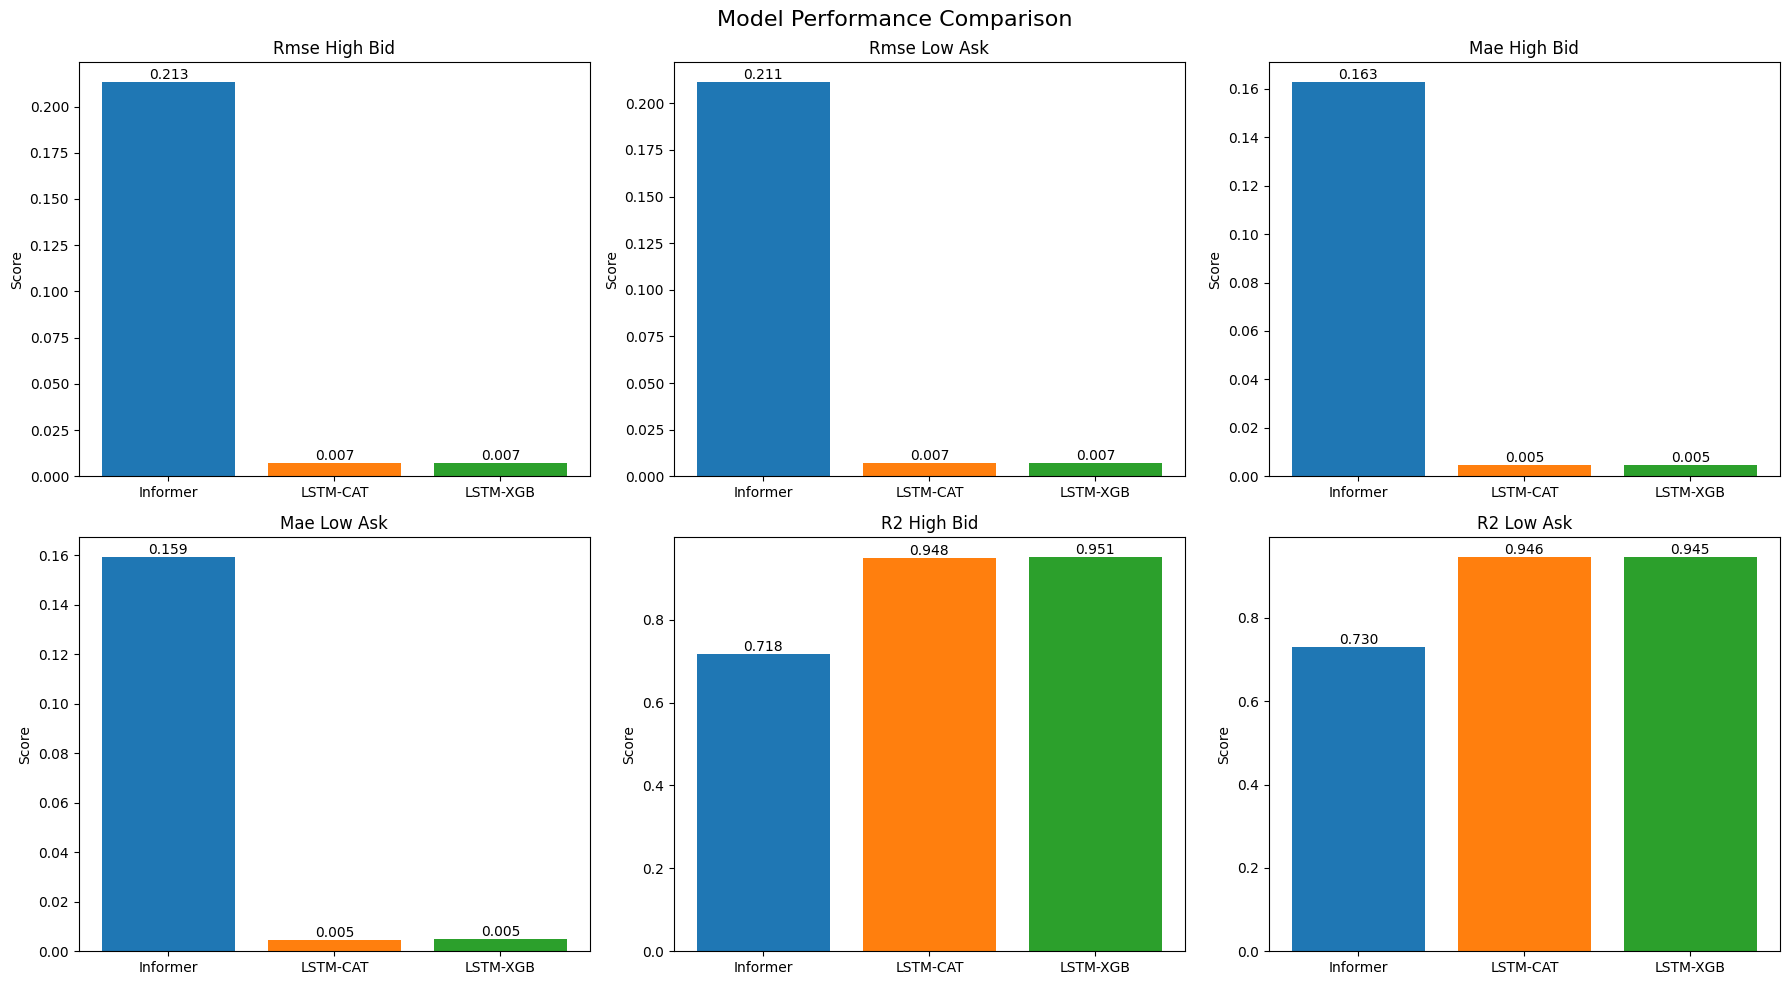

In [39]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_60min_Informer_15minDF,
    'LSTM-CAT': avg_results_next_60min_LSTM_CAT_15minDF,
    'LSTM-XGB': avg_results_next_60min_LSTM_XGB_15minDF
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

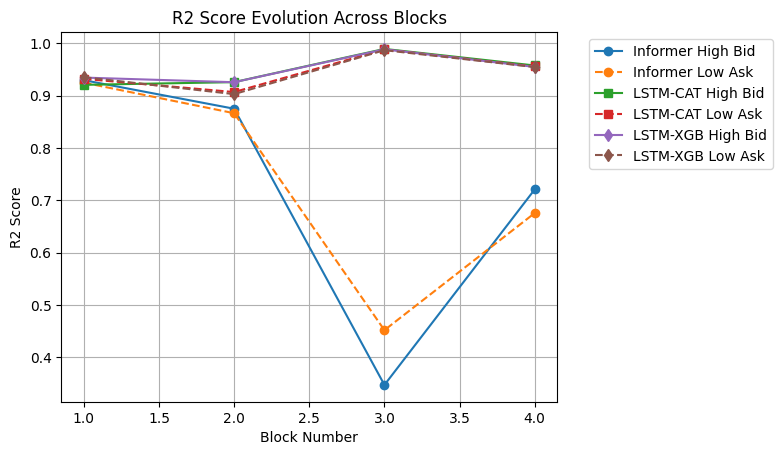

In [41]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_60min_Informer_15minDF)+1)

# Plot R2 evolution
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

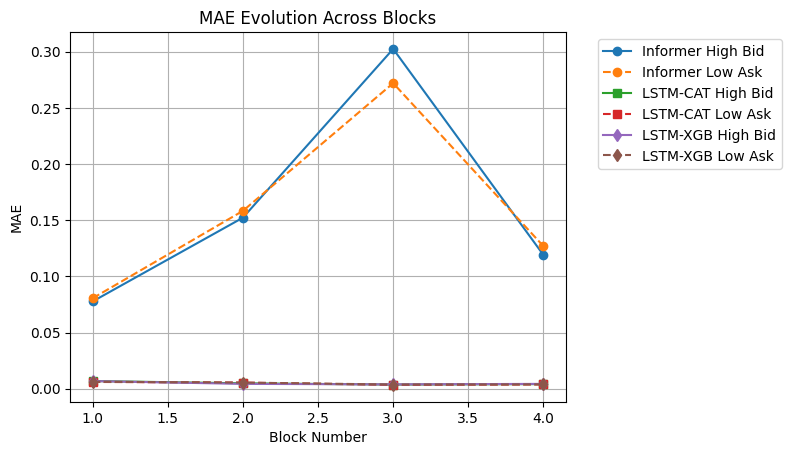

In [42]:
# Plot MAE evolution
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_Informer_15minDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_Informer_15minDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_CAT_15minDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_CAT_15minDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_XGB_15minDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_XGB_15minDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

In [43]:
#
#
#
# 1 hour df
#
#
#

In [178]:
df_1h = pd.read_csv('cleaned_XAUUSD_1_Hour_01.01.2024-29.03.2025.csv', low_memory=False, sep=',')
df_1h.iloc[5000:5007]

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Local_Time,Open_BID,High_BID,Low_BID,Close_BID,...,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,Y_High_BID,Y_Low_ASK,New_Day,New_Week
5000,2.388135,2.388135,2.388135,2.388135,0.0,2024-07-27 08:00:00+00:00,2.386765,2.386765,2.386765,2.386765,...,0.712388,0.0,1.37,1.37,1.37,1.37,2.386765,2.388135,0,0
5001,2.388135,2.388135,2.388135,2.388135,0.0,2024-07-27 09:00:00+00:00,2.386765,2.386765,2.386765,2.386765,...,0.712388,0.0,1.37,1.37,1.37,1.37,2.386765,2.388135,0,0
5002,2.388135,2.388135,2.388135,2.388135,0.0,2024-07-27 10:00:00+00:00,2.386765,2.386765,2.386765,2.386765,...,0.712388,0.0,1.37,1.37,1.37,1.37,2.386765,2.388135,0,0
5003,2.388135,2.388135,2.388135,2.388135,0.0,2024-07-27 11:00:00+00:00,2.386765,2.386765,2.386765,2.386765,...,0.712388,0.0,1.37,1.37,1.37,1.37,2.386765,2.388135,0,0
5004,2.388135,2.388135,2.388135,2.388135,0.0,2024-07-27 12:00:00+00:00,2.386765,2.386765,2.386765,2.386765,...,0.712388,0.0,1.37,1.37,1.37,1.37,2.386765,2.388135,0,0
5005,2.388135,2.388135,2.388135,2.388135,0.0,2024-07-27 13:00:00+00:00,2.386765,2.386765,2.386765,2.386765,...,0.712388,0.0,1.37,1.37,1.37,1.37,2.386765,2.388135,0,0
5006,2.388135,2.388135,2.388135,2.388135,0.0,2024-07-27 14:00:00+00:00,2.386765,2.386765,2.386765,2.386765,...,0.712388,0.0,1.37,1.37,1.37,1.37,2.386765,2.388135,0,0


In [177]:
df_1h_informer = pd.read_csv('./cleaned_XAUUSD_1_Hour_01.01.2024-29.03.2025_for_informer.csv')
df_1h_informer.head()

,date,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
0,2024-01-01 00:00:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.712388,0.0,0.424,0.424,0.424,0.424,0,0
1,2024-01-01 01:00:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.712388,0.0,0.424,0.424,0.424,0.424,0,0
2,2024-01-01 02:00:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.712388,0.0,0.424,0.424,0.424,0.424,0,0
3,2024-01-01 03:00:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.712388,0.0,0.424,0.424,0.424,0.424,0,0
4,2024-01-01 04:00:00+00:00,2.063112,2.063112,2.063112,2.063112,0.0,2.062688,2.062688,2.062688,2.062688,0.0,0.712388,0.0,0.424,0.424,0.424,0.424,0,0


In [46]:
'''
We will predict the Highest and Lowest prices for the next 60 minutes.

To do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (1 row)

Then you need to delete the last row since there are no prices for the next 60 minutes.
Therefore, we will create an array of answers "data_ay" with the 
Highest and Lowest prices shifted sequentially to 1 row up.
'''

'\nWe will predict the Highest and Lowest prices for the next 60 minutes.\n\nTo do this in the data output (vector of answers), we shift prices sequentially to 60 minutes up (1 row)\n\nThen you need to delete the last row since there are no prices for the next 60 minutes.\nTherefore, we will create an array of answers "data_ay" with the \nHighest and Lowest prices shifted sequentially to 1 row up.\n'

In [229]:
inputs_data = df_1h.drop(['Local_Time', 'Y_High_BID', 'Y_Low_ASK'], axis=1)
inputs_data.shape

(10896, 18)

In [230]:
outputs_data = df_1h[['Y_High_BID', 'Y_Low_ASK']]
outputs_data.shape

(10896, 2)

In [231]:
print(outputs_data.tail(2), '\n')
outputs_data = outputs_data.shift(-1)
print(outputs_data.tail(2))

       Y_High_BID  Y_Low_ASK
10894    3.083898   3.086702
10895    3.083898   3.086702 

       Y_High_BID  Y_Low_ASK
10894    3.083898   3.086702
10895         NaN        NaN


In [232]:
outputs_data.drop(outputs_data.shape[0]-1, axis=0, inplace=True)
outputs_data.tail(2)

,Y_High_BID,Y_Low_ASK
10893,3.083898,3.086702
10894,3.083898,3.086702


In [233]:
inputs_data.drop(inputs_data.shape[0]-1, axis=0, inplace=True)
inputs_data.tail(2)

,Open_ASK,High_ASK,Low_ASK,Close_ASK,Volume_ASK,Open_BID,High_BID,Low_BID,Close_BID,Volume_BID,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Close_Delta,New_Day,New_Week
10893,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.712388,0.0,2.804,2.804,2.804,2.804,0,0
10894,3.086702,3.086702,3.086702,3.086702,0.0,3.083898,3.083898,3.083898,3.083898,0.0,0.712388,0.0,2.804,2.804,2.804,2.804,0,0


In [234]:
data_x = np.array(inputs_data)
data_y = np.array(outputs_data)
print('inputs Numpy array size:', data_x.shape, '\noutputs Numpy array size:', data_y.shape)

inputs Numpy array size: (10895, 18) 
outputs Numpy array size: (10895, 2)


In [235]:
N = 25
L = data_x.shape[0] - N
t = data_x.shape[1]
print('Size of a three-dimensional inputs tensor:', L, N, t)

Size of a three-dimensional inputs tensor: 10870 25 18


In [236]:
# create inputs zeros 3D tensors with 'float32'
data_in = np.zeros( (L, N, t), dtype= 'float32' )

# create a 2D zeros vector of answers
data_out = np.zeros((L, 2), dtype= 'float32')

In [237]:
# fill the inputs 3D tensor (data_in)
# and the array of answers data_out

for k in tqdm(range(L)):
    data_in[k, :, :] = data_x[k:k+N, :]

    data_out[k,0] = data_y[k+N-1,0]   # normalised Y_High_Bid - max 10 minutes future price
    data_out[k,1] = data_y[k+N-1,1]   # normalised Y_Low_Ask -  min 10 minutes future price

print('data_in:', '\n', data_in[:3, :])
print('\n\n')
print('data_out:', '\n', data_out[:3, :])

100%|████████████████████████████████████████████████████████████████████████| 10870/10870 [00:00<00:00, 241330.11it/s]

data_in: 
 [[[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.064562 2.067475 2.063395 ... 0.381    0.       0.      ]
  [2.063996 2.066045 2.062572 ... 0.327    1.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.064562 2.067475 2.063395 ... 0.381    0.       0.      ]
  [2.063996 2.066045 2.062572 ... 0.327    1.       0.      ]
  [2.065565 2.070135 2.065085 ... 0.351    0.       0.      ]]

 [[2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  [2.063112 2.063112 2.063112 ... 0.424    0.       0.      ]
  ...
  [2.063996 2.066045 2.062572 ... 0.3

In [238]:
print('inputs 3D tensor size:', data_in.shape, '\noutputs 2D vector size:', data_out.shape)

inputs 3D tensor size: (10870, 25, 18) 
outputs 2D vector size: (10870, 2)


In [239]:
train_size, test_size = 5000, 800

In [240]:
X_trains, X_tests, y_trains, y_tests = walk_forward_split(data_in, data_out, train_size, test_size)

In [241]:
print(f"Number of walk-forward blocks: {len(X_trains)}")
print(f"Shape of first training block X: {X_trains[0].shape}")
print(f"Shape of first testing block X: {X_tests[0].shape}")
print(f"Shape of last training block X: {X_trains[len(X_trains)-1].shape}")
print(f"Shape of last testing block X: {X_tests[len(X_trains)-1].shape}")

Number of walk-forward blocks: 2
Shape of first training block X: (5000, 25, 18)
Shape of first testing block X: (800, 25, 18)
Shape of last training block X: (5000, 25, 18)
Shape of last testing block X: (800, 25, 18)


In [218]:
number_of_blocks_for_informer_1hDF = walk_forward_split_for_informer(df_1h_informer, './walk_forward_data_split_informer_1hDF', train_size, test_size)

Start: 0 | End Train: 5000 | End Test: 5800
Block 0 | Rows: 5800 | Columns: 19 | Path: ./walk_forward_data_split_informer_1hDF\walk_forward_block_0.csv
Start: 5000 | End Train: 10000 | End Test: 10800
Block 1 | Rows: 5800 | Columns: 19 | Path: ./walk_forward_data_split_informer_1hDF\walk_forward_block_1.csv


In [219]:
print(f"Number of walk-forward blocks for training Informer: {number_of_blocks_for_informer_1hDF}")

Number of walk-forward blocks for training Informer: 2


In [242]:
#
# LSTM-XGBOOST model
#

In [243]:
results_next_60min_LSTM_XGB_1hDF = []

In [244]:
LSTM_model_for_xgb = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])

LSTM_model_for_xgb.summary()

LSTM_model_for_xgb.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [245]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_xgb.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_xgb.predict(X_trains[i])
    test_features = LSTM_model_for_xgb.predict(X_tests[i])

    # XGBoost on extracted features
    xgb_high_bid = xgb.XGBRegressor()
    xgb_low_ask = xgb.XGBRegressor()
    
    xgb_high_bid.fit(train_features, y_trains[i][:, 0])
    xgb_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = xgb_high_bid.predict(test_features)
    pred_low_ask = xgb_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_XGB_1hDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2900 - val_loss: 0.0018
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 9.5828e-04 - val_loss: 3.2286e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.0434e-04 - val_loss: 2.0111e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2.2095e-04 - val_loss: 2.9593e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.4016e-04 - val_loss: 1.9468e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2438e-04 - val_loss: 1.1607e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1573e-04 - val_loss: 9.9968e-05
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0098e-04 - val_loss: 9.8027e-05
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9.0629e-05 - val_loss: 9.3191e-05
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.4754e-05 - val_loss: 8.0321e-05
Epoch 11/100
125

In [246]:
metrics_next_60min_LSTM_XGB_1hDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_XGB_1hDF = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_XGB_1hDF]) for metric in metrics_next_60min_LSTM_XGB_1hDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_XGB_1hDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0352
Average rmse_low_ask: 0.0380
Average mae_high_bid: 0.0242
Average mae_low_ask: 0.0263
Average r2_high_bid: 0.5365
Average r2_low_ask: 0.4688


In [247]:
#
# LSTM-CATBOOST model
#

In [248]:
results_next_60min_LSTM_CAT_1hDF = []

In [249]:
LSTM_model_for_cat = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(N, data_in.shape[2])),
    keras.layers.Dense(2)
])
LSTM_model_for_cat.summary()
LSTM_model_for_cat.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 64)                  │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,378 (83.51 KB)

 Trainable params: 21,378 (83.51 KB)

 Non-trainable params: 0 (0.00 B)

In [250]:
for i in range(len(X_trains)):
    print(f"\n--- Walk-Forward Block {i+1} ---")

    LSTM_model_for_cat.fit(X_trains[i], y_trains[i], epochs=100, verbose=1, validation_split=0.2, callbacks=[es])

    # LSTM Feature Extraction
    train_features = LSTM_model_for_cat.predict(X_trains[i])
    test_features = LSTM_model_for_cat.predict(X_tests[i])

    # XGBoost on extracted features
    catboost_high_bid = CatBoostRegressor(verbose=0)
    catboost_low_ask = CatBoostRegressor(verbose=0)
    
    catboost_high_bid.fit(train_features, y_trains[i][:, 0])
    catboost_low_ask.fit(train_features, y_trains[i][:, 1])

    pred_high_bid = catboost_high_bid.predict(test_features)
    pred_low_ask = catboost_low_ask.predict(test_features)

    rmse_high_bid = np.sqrt(mean_squared_error(y_tests[i][:, 0], pred_high_bid))
    rmse_low_ask = np.sqrt(mean_squared_error(y_tests[i][:, 1], pred_low_ask))
    mae_high_bid = mean_absolute_error(y_tests[i][:, 0], pred_high_bid)
    mae_low_ask = mean_absolute_error(y_tests[i][:, 1], pred_low_ask)
    r2_high_bid = r2_score(y_tests[i][:, 0], pred_high_bid)
    r2_low_ask = r2_score(y_tests[i][:, 1], pred_low_ask)
    
    
    print(f"RMSE High_BID: {rmse_high_bid:.4f} | RMSE Low_ASK: {rmse_low_ask:.4f}")
    print(f"MAE High_BID: {mae_high_bid:.4f} | MAE Low_ASK: {mae_low_ask:.4f}")
    print(f"R2 High_BID:  {r2_high_bid:.4f} | R2 Low_ASK:  {r2_low_ask:.4f}")

    results_next_60min_LSTM_CAT_1hDF.append({
        'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
        'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
        'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
    })


--- Walk-Forward Block 1 ---
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4152 - val_loss: 0.0013
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.1773e-04 - val_loss: 2.5136e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1174e-04 - val_loss: 2.5859e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6896e-04 - val_loss: 3.1774e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7082e-04 - val_loss: 1.8678e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4566e-04 - val_loss: 1.1522e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0727e-04 - val_loss: 1.4100e-04
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2145e-04 - val_loss: 1.6016e-04
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0665e-04 - val_loss: 1.1940e-04
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1803e-05 - val_loss: 7.1859e-05
Epoch 11/100
125/125 ━━━━

In [251]:
metrics_next_60min_LSTM_CAT_1hDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_LSTM_CAT_1hDF = {metric: np.mean([r[metric] for r in results_next_60min_LSTM_CAT_1hDF]) for metric in metrics_next_60min_LSTM_CAT_1hDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_LSTM_CAT_1hDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.0356
Average rmse_low_ask: 0.0381
Average mae_high_bid: 0.0246
Average mae_low_ask: 0.0261
Average r2_high_bid: 0.5262
Average r2_low_ask: 0.4655


In [220]:
#
# Informer model
#

In [221]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = '.' # root path of data file
#args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'Low_ASK' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 18 # encoder input size
args.dec_in = 18 # decoder input size
args.c_out = 18 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 1024 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = False # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 25
args.patience = 7
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [222]:
Informer_model = Exp_Informer

In [223]:
results_next_60min_Informer_1hDF = []

In [224]:
results_dir = './results'

for i in range(number_of_blocks_for_informer_1hDF):
    args.data_path = f'walk_forward_data_split_informer_1hDF/walk_forward_block_{i}.csv'
    
    setting = '{}_walk{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}'.format(
        args.model, i, args.features, args.seq_len, args.label_len, args.pred_len,
        args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff,
        args.attn, args.factor, args.embed, args.distil, args.mix, args.des)

    metrics_path = os.path.join(results_dir, setting, 'metrics.npy')
    
    exp = Informer_model(args)
    
    print(f">>>>>> Start training block {i+1}: {setting}")
    exp.train(setting)
    
    print(f">>>>>> Testing block {i+1}: {setting}")
    exp.test(setting)

    if os.path.exists(metrics_path):
        metrics = np.load(metrics_path)
        rmse_high_bid, rmse_low_ask, mae_high_bid, mae_low_ask, r2_high_bid, r2_low_ask = metrics

        results_next_60min_Informer_1hDF.append({
            'rmse_high_bid': rmse_high_bid, 'rmse_low_ask': rmse_low_ask,
            'mae_high_bid': mae_high_bid, 'mae_low_ask': mae_low_ask,
            'r2_high_bid': r2_high_bid, 'r2_low_ask': r2_low_ask
        })
    else:
        print(f"Missing metrics for block {i+1}")
    
    torch.cuda.empty_cache()

Use CPU
>>>>>> Start training block 1: informer_walk0_ftM_sl96_ll48_pl1_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtFalse_mxTrue_exp
train 3963
val 581
test 1160
	iters: 100, epoch: 1 | loss: 0.2519394
	speed: 6.2708s/iter; left time: 18661.8414s
Epoch: 1 cost time: 776.3161106109619
Epoch: 1, Steps: 123 | Train Loss: 0.4380631 Vali Loss: 0.3058320 Test Loss: 0.4932737
Validation loss decreased (inf --> 0.305832).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1275083
	speed: 9.2649s/iter; left time: 26432.7563s
Epoch: 2 cost time: 817.0919089317322
Epoch: 2, Steps: 123 | Train Loss: 0.2865881 Vali Loss: 0.2005621 Test Loss: 0.2877542
Validation loss decreased (0.305832 --> 0.200562).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.2128913
	speed: 9.2144s/iter; left time: 25155.2207s
Epoch: 3 cost time: 805.9804065227509
Epoch: 3, Steps: 123 | Train Loss: 0.2043291 Vali Loss: 0.1823042 Test Loss: 0.2578034
Validat

In [225]:
metrics_next_60min_Informer_1hDF = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
avg_results_next_60min_Informer_1hDF = {metric: np.mean([r[metric] for r in results_next_60min_Informer_1hDF]) for metric in metrics_next_60min_Informer_1hDF}

print("\n=== AVERAGE METRICS ACROSS ALL BLOCKS ===")
for metric, value in avg_results_next_60min_Informer_1hDF.items():
    print(f"Average {metric}: {value:.4f}")


=== AVERAGE METRICS ACROSS ALL BLOCKS ===
Average rmse_high_bid: 0.3671
Average rmse_low_ask: 0.3398
Average mae_high_bid: 0.2982
Average mae_low_ask: 0.2746
Average r2_high_bid: 0.3791
Average r2_low_ask: 0.4683


In [ ]:
#
# Visualisation
#

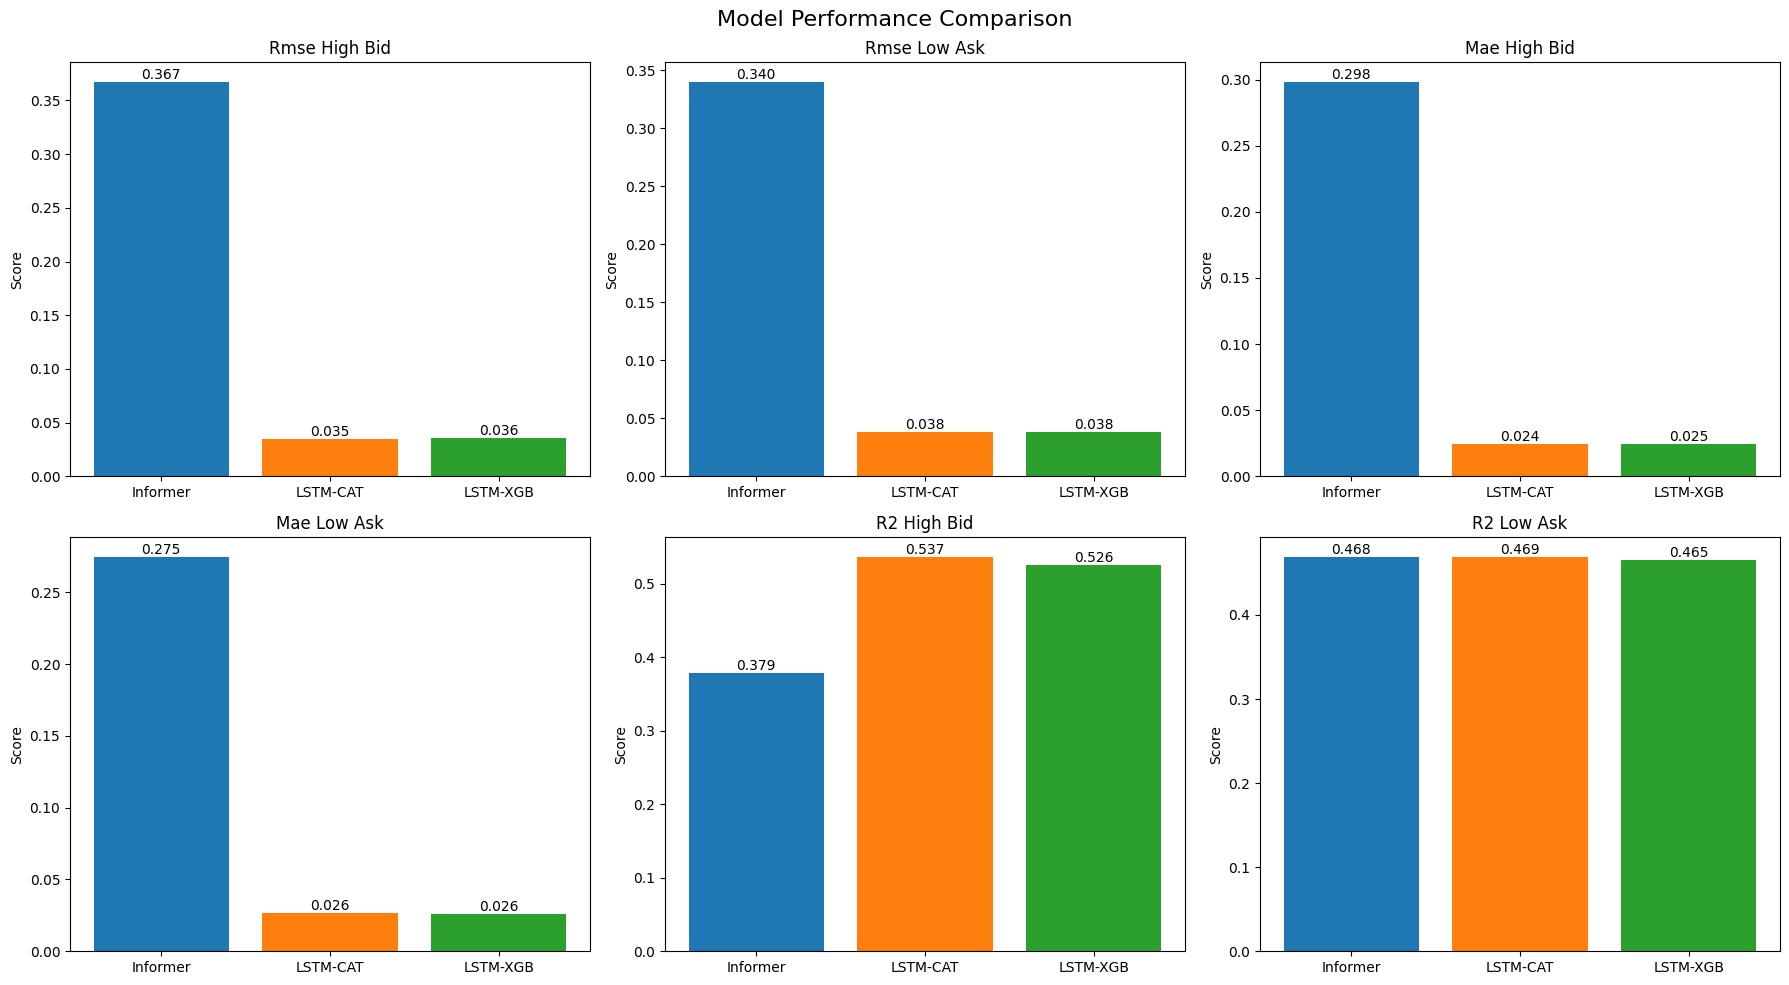

In [254]:
import matplotlib.pyplot as plt

# Prepare data
models = ['Informer', 'LSTM-CAT', 'LSTM-XGB']
metrics = ['rmse_high_bid', 'rmse_low_ask', 'mae_high_bid', 'mae_low_ask', 'r2_high_bid', 'r2_low_ask']
data = {
    'Informer': avg_results_next_60min_Informer_1hDF,
    'LSTM-CAT': avg_results_next_60min_LSTM_CAT_1hDF,
    'LSTM-XGB': avg_results_next_60min_LSTM_XGB_1hDF
}

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    values = [data[model][metric] for model in models]
    
    # Handle negative R2 cases
    if 'r2' in metric:
        values = [max(0, v) for v in values]  # Clip negative R2 to 0 for visualization
    
    bars = ax.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_ylabel('Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

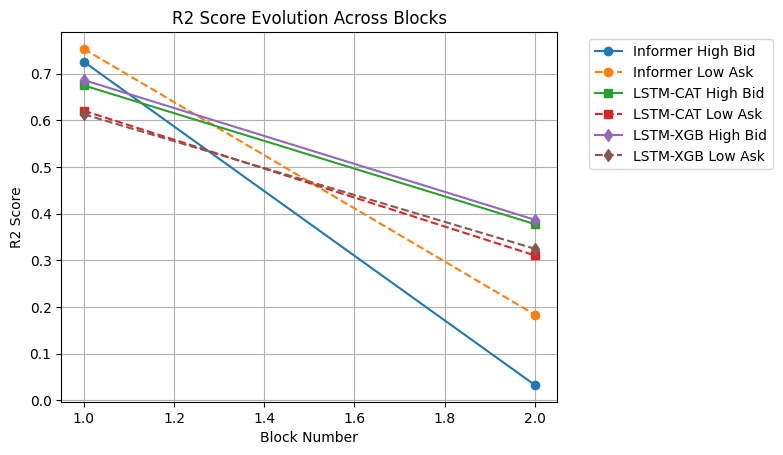

In [256]:
# Prepare block-wise data
blocks = np.arange(1, len(results_next_60min_Informer_1hDF)+1)

# Plot R2 evolution
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_Informer_1hDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_Informer_1hDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_CAT_1hDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_CAT_1hDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['r2_high_bid'] for x in results_next_60min_LSTM_XGB_1hDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['r2_low_ask'] for x in results_next_60min_LSTM_XGB_1hDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('R2 Score Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

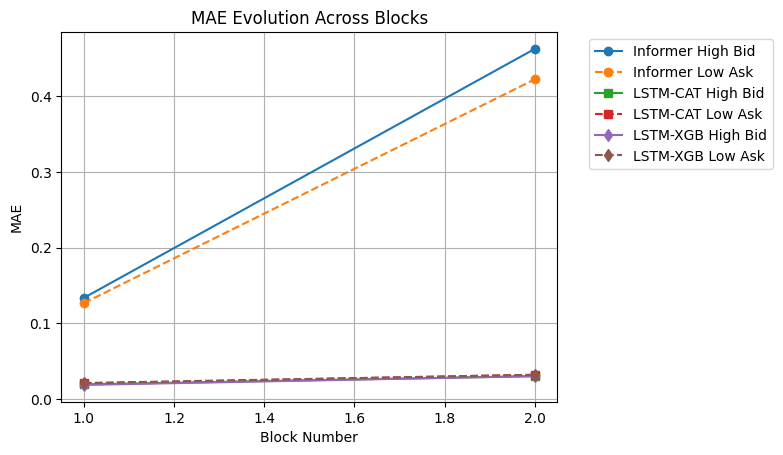

In [257]:
# Plot MAE evolution
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_Informer_1hDF], 'o-', label='Informer High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_Informer_1hDF], 'o--', label='Informer Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_CAT_1hDF], 's-', label='LSTM-CAT High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_CAT_1hDF], 's--', label='LSTM-CAT Low Ask')
plt.plot(blocks, [x['mae_high_bid'] for x in results_next_60min_LSTM_XGB_1hDF], 'd-', label='LSTM-XGB High Bid')
plt.plot(blocks, [x['mae_low_ask'] for x in results_next_60min_LSTM_XGB_1hDF], 'd--', label='LSTM-XGB Low Ask')

plt.title('MAE Evolution Across Blocks')
plt.xlabel('Block Number')
plt.ylabel('MAE')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()